# Abstract

## Overview

In February of 2019, tens of thousands of domestic flights carried passengers around the country—every single day. Tens of thousands of aircraft being carefully tracked, monitored, organized and directed, and hundred of thousands or even millions of passengers count on those planes to get them where they're going. It's an incredible system, and most of the time it actually works. But when it doesn't, it hurts. Flight cancellations are extremely expensive, costing airlines a $1 billion per year. While flight cancellations due to weather may be inevitable, a significant portion of cancellations are due to circumstances under _our_ control. Modern air traffic control is a hundred years in the making and has certainly worked to minimize this issue already, but…can we do better?

## Question

Using data on American commercial flights, can we predict when a cancellation is likely to occur? As a bonus, can we predict _why_ the cancellation will occur?


*This is your space to describe your intentions for the project, before writing a single line of code. What are you studying? What are you hoping to build? If you can't explain that clearly before you start digging into the data, you're going to have a hard time planning where to go with this.*

# Obtain the Data

*Describe your data sources here and explain why they are relevant to the problem you are trying to solve.*

*Your code should download the data and save it in data/raw. If you've got the data from an offline source, describe where it came from and what the files look like. Don't do anything to the raw data files just yet; that comes in the next step.*

## Data Sources

My data set will be primarily based around the "[Marketing Carrier On-Time Performance](https://www.transtats.bts.gov/DatabaseInfo.asp?DB_ID=120&DB_URL=)" report released by the Bureau of Transportation Statistics. This database contains information on nearly every flight conducted by a significant U.S. carrier dating back to January 2018, which amounts to approximately 8 million observations. I expect I will supplement this dataset with additional features such as weather forecasts preceding a flight and additional statistics surrounding the model of plane for each flight.

*After completing this step, be sure to edit `references/data_dictionary` to include descriptions of where you obtained your data and what information it contains.*

In [7]:
## %%writefile ../src/data/make_dataset.py

# Imports
from io import BytesIO
import os
import urllib.request
from zipfile import ZipFile
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
import sqlalchemy
from sqlalchemy import create_engine
import datetime
from pytz import timezone
from datetime import timedelta
import pytz
import json
import requests
import numpy as np
import pandas as pd

# Helper functions


def get_lookup_tables():
    # Reporting carrier lookup table
    'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_UNIQUE_CARRIERS'
    # Reporting airline lookup table
    'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_AIRLINE_ID'
    # Airport ID lookup table
    'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_AIRPORT_ID'
    # City Market ID lookup table
    'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_CITY_MARKET_ID'
    # Airport lookup table (SEA -> Seattle-Tacoma International)
    'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_AIRPORT'
    
    lookups = [
        'L_UNIQUE_CARRIERS',
        'L_AIRLINE_ID',
        'L_AIRPORT_ID',
        'L_CITY_MARKET_ID',
        'L_AIRPORT',
        'L_AIRPORT_ID',
        'L_CITY_MARKET_ID'
    ]
    lookup_base = 'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup='
    for table in lookups:
        download_lookup(lookup_base + table)
    pass


def get_weather_forecast_url(lat, lon, time):
    """
    """
    # Weather forecast API
    'https://darksky.net/dev/docs#time-machine-request'
    key = 'c00a48b4e746f7a6b5a4caef59e18dc9'
    # Example
    base = 'https://api.darksky.net/forecast/'
    tail = '?exclude=currently,flags'
    url = f'{base}{key}/{lat},{lon},{time}{tail}'
    
    return url


def get_weather_data(start_date, end_date, overwrite='ask'):
    """
    """
    if overwrite == 'ask':
        overwrite = input(f'Get weather data? y/n: ')
    if overwrite.lower() != 'y':
        return
    
    table = 'weather'
    params = {
        'user': 'scottbutters',
        'host': '127.0.0.1',
        'port': 5432,
        'dbname': 'raw_flight_data'
    }
    
    connection_string = f"postgresql:///{params['dbname']}"
    engine = create_engine(connection_string)
    
    # SeaTac Coordinates
    lat = 47.4502
    lon = -122.3088
    
    date = end_date
    print(f'Getting weather data for {date} to {end_date}...')
    while date > start_date:
        e_date = date.strftime("%s")
        url = get_weather_forecast_url(lat, lon, e_date)
#         try:
        r = requests.get(url)
        if r.ok:
            day_weather = r.json()
            data = pd.DataFrame(day_weather['hourly']['data'])
            data['datetime'] = pd.to_datetime(data['time'], unit='s')
            data['date'] = data['datetime'].dt.date
            data['hour'] = data['datetime'].dt.hour - 8
            try:
                data.to_sql(table, engine, if_exists='append', index=False)
            except:
                print(f'Failed to append {date} to table.')
        else:
            print(f'No data for {date}. Error {r.status_code}')
        date -= timedelta(days=1)
        if date.strftime('%m-%d') == '01-01':
            year = date.strftime('%Y')
            print(f'Collected data for {year}')
    print(f'Wrote weather data from {start_date} to {end_date} to table {table}')
    return


def file_exists(path, filename):
    filepath = path + filename
    file_exists = os.path.isfile(filepath)
    return file_exists

    
def download_dataset(url, path, filename, overwrite='ask'):
    """
    Downloads zip file from specified url and extracts csv file to raw data 
    directory
    Input: 
        url: string of url from which to retrieve data
        path: string of directory path to store file in
        filename: string of desired filename
        overwrite: parameter for whether or not to overwrite existing files, if
            found. If 'y', any existing file with filename in path will be
            overwritten. If 'n', function will do nothing. If 'ask', function
            will prompt user to decide whether or not to replace file.
    Output: dataset stored in raw data directory
    """
    filepath = path + filename
    if file_exists(path, filename):
        if overwrite == 'ask':
            overwrite = input(f'{filename} already exists. Update? y/n: ')
        if overwrite.lower() != 'y':
            return
                              
    print(f'Beginning download of {filename}...')
    try:
        zip_f = urllib.request.urlopen(url)
        with ZipFile(BytesIO(zip_f.read())) as my_zip_file:
            for f in my_zip_file.namelist():
                if '.csv' in f:
                    with open(filepath, 'wb') as output:
                        for line in my_zip_file.open(f).readlines():
                            output.write(line)
        print(f'Successfully wrote {filename} to {path}')
                              
    except urllib.request.HTTPError:
        print(f'Failed to download {filename}')
        return


def get_flight_data_url(year, month):
    '''
    Generate URL to download pre-zipped csv of flight data for a given month as
    provided by the Bureau of Transportation Statistics
    Input: Year in format YYYY (int), Month in format of (M)M, i.e. 3, or 11
    Output: download URL as a string
    '''
    base_url = 'http://transtats.bts.gov/PREZIP/'
    tail = 'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_'
    slug = f'{year}_{month}.zip'
    return base_url + tail + slug
    

def get_flight_data(start, end, path, overwrite='ask'):
    '''
    Downloads a variety of flight data tables from:
    https://www.transtats.bts.gov/Fields.asp
    '''
    # Download all BTS datasets
    for year in range(start, end):
        for month in range(1,13):
            filename = f'flight_data_{year}-{month}.csv'
            url = get_flight_data_url(year, month)
            download_dataset(url, path, filename, overwrite)
    pass


def run():
    """
    Executes a set of helper functions that download data from one or more sources
    and saves those datasets to the data/raw directory.
    """
    path = '../data/raw/'
#     get_flight_data(2003, 2020, path, overwrite='n')
    
    pacific = timezone('US/Pacific')
    start = datetime.datetime(2003, 1, 1, 0, 0, 0, tzinfo=pacific)
    end = datetime.datetime(2019, 4, 30, 0, 0, 0, tzinfo=pacific)
    get_weather_data(start, end, overwrite='ask')
    # download_dataset_1(url)
    # download_dataset_2(url)
    # save_dataset_1('data/raw', filename)
    # save_dataset_2('data/raw', filename)
    pass

In [8]:
run()

Get weather data? y/n: y
Getting weather data for 2019-04-30 00:00:00-07:53 to 2019-04-30 00:00:00-07:53...
Failed to append 2019-03-08 00:00:00-07:53 to table.
Failed to append 2019-03-07 00:00:00-07:53 to table.
Failed to append 2019-02-11 00:00:00-07:53 to table.
Failed to append 2019-02-10 00:00:00-07:53 to table.
Failed to append 2019-02-09 00:00:00-07:53 to table.
Failed to append 2019-02-08 00:00:00-07:53 to table.
Failed to append 2019-02-06 00:00:00-07:53 to table.
Failed to append 2019-02-05 00:00:00-07:53 to table.
Failed to append 2019-02-04 00:00:00-07:53 to table.
Failed to append 2019-02-03 00:00:00-07:53 to table.
Collected data for 2019
Failed to append 2018-02-25 00:00:00-07:53 to table.
Failed to append 2018-02-24 00:00:00-07:53 to table.
Failed to append 2018-02-23 00:00:00-07:53 to table.
Failed to append 2018-02-22 00:00:00-07:53 to table.
Failed to append 2018-02-18 00:00:00-07:53 to table.
Collected data for 2018
Failed to append 2017-12-26 00:00:00-07:53 to tab

In [2]:
for i in range(10):
    if i % 2 == 1:
        pass
    print(i)

0
1
2
3
4
5
6
7
8
9


In [ ]:
df = pd.read_csv('../data/raw/On_Time_Marketing_Carrier_On_Time_Performance_(Beginning_January_2018)_2019_2.csv')

In [ ]:
df.shape

In [ ]:
print(list(df.columns))

In [ ]:
df['CancellationCode'].value_counts()

In [ ]:
df.head()

In [ ]:
pd.Series(df['DayofMonth'].value_counts()).mean()

In [ ]:
df.groupby('DayofMonth')['Cancelled'].value_counts()

# Scrub the Data

*Look through the raw data files and see what you will need to do to them in order to have a workable data set. If your source data is already well-formatted, you may want to ask yourself why it hasn't already been analyzed and what other people may have overlooked when they were working on it. Are there other data sources that might give you more insights on some of the data you have here?*

*The end goal of this step is to produce a [design matrix](https://en.wikipedia.org/wiki/Design_matrix), containing one column for every variable that you are modeling, including a column for the outputs, and one row for every observation in your data set. It needs to be in a format that won't cause any problems as you visualize and model your data.*

## Features
The following is a list of features I'd like to have in the design matrix:


| Feature                               | Description                                                  | Type        | Purpose |
| ------------------------------------- | ------------------------------------------------------------ | ----------- | ------- |
| Airline ID                            | ID number to identify unique airline                         | Categorical | Key     |
| AL_C_rate_day                         | Flight cancellation rate by this airline at this airport over past 24 hours | Continuous  | Feature |
| AL_C_rate_7                           | Flight cancellation rate by this airline on this weekday 1 week ago | Continuous  | Feature |
| AL_C_avg_rate_week                    | Flight cancellation rate by this airline at this airport over past 7 days | Continuous  | Feature |
| AL_C_rate_28                          | Flight cancellation rate by this airline on this weekday 4 weeks ago | Continuous  | Feature |
| AL_C_avg_rate_month                   | Flight cancellation rate by this airline at this airport over past 30 days | Continuous  | Feature |
| AL_C_rate_364                         | Flight cancellation rate by this airline on this weekday 52 weeks ago | Continuous  | Feature |
| AL_C_avg_rate_year                    | Flight cancellation rate by this airline at this airport over past 365 days | Continuous  | Feature |
| Tail number                           | Unique airplane identifier ID                                | Categorical | Key     |
| AP_C_rate_day                         | Flight cancellation rate by this airplane over past 24 hours | Continuous  | Feature |
| AP_C_rate_7                           | Flight cancellation rate by this airplane on this weekday 1 week ago | Continuous  | Feature |
| AP_C_avg_rate_week                    | Flight cancellation rate by this airplane at this airport over past 7 days | Continuous  | Feature |
| AP_C_rate_28                          | Flight cancellation rate by this airplane on this weekday 4 weeks ago | Continuous  | Feature |
| AP_C_avg_rate_month                   | Flight cancellation rate by this airplane at this airport over past 30 days | Continuous  | Feature |
| AP_C_rate_364                         | Flight cancellation rate by this airplane on this weekday 52 weeks ago | Continuous  | Feature |
| AP_C_avg_rate_year                    | Flight cancellation rate by this airplane at this airport over past 365 days | Continuous  | Feature |
| Origin Airport ID                     | Unique airport identifier ID for flight origin               | Categorical | Key     |
| orig_C_rate_day                       | Flight cancellation rate for flights departing from origin airport over past 24 hours | Continuous  | Feature |
| repeat same pattern as above          |                                                              |             |         |
| Origin City Market                    | ID for area that may be served by several airlines           | Categorical | Key     |
| OCM_C_rate_day                        | Flight cancellation rate for flights departing from origin city market over past 24 hours | Continuous  | Feature |
| repeat same pattern as above          |                                                              |             |         |
| Dest Airport ID                       | Unique airport identifier ID for destination                 | Categorical | Key     |
| dest_C_rate_day                       | Flight cancellation rate for flights heading to destination airport over past 24 hours | Continuous  | Feature |
| repeat same pattern as above          |                                                              |             |         |
| Dest City Market                      | ID for area that may be served by several airlines           | Categorical | Key     |
| DCM_C_rate_day                        | Flight cancellation rate for flights heading to destination city market over past 24 hours | Continuous  | Feature |
| repeat same pattern as above          |                                                              |             |         |
| Departure time                        | Scheduled departure time                                     | ?           |         |
| Airtime                               | Planned time in air, in minutes                              | Continuous  |         |
| Distance                              | Planned route distance                                       | Continuous  |         |
| On-time incoming arrival percentage   | Percent of flights that arrive at departure airport on-time  | Continuous  |         |
| On-time outgoing departure percentage | Percent of flights that depart from departure airport on-time | Continuous  |         |
| Historical cancellation percentages   | All time average                                             | Continuous  |         |
|                                       | 1 day ago                                                    | Continuous  |         |
|                                       | 7 days ago                                                   | Continuous  |         |
|                                       | 30 days ago                                                  | Continuous  |         |
|                                       | 364 days ago                                                 | Continuous  |         |
|                                       | For this airline                                             | Continuous  |         |
|                                       | From this airport                                            | Continuous  |         |
|                                       | To that airport                                              | Continuous  |         |
|                                       | On this airplane (tail number)                               | Continuous  |         |
|                                       | On this airplane model                                       | Continuous  |         |
| Historical delays (goes back to 2003) | The average number of minutes that a similar incoming flight has been delayed (in minutes) over the avove time periods, for the reasons: carrier delay, weather delay, national air system delay, security delay, and late aircraft delay |             |         |
|                                       |                                                              |             |         |
| Weather Forecast                      | What the weather forecast was ~24 hours ago, in degrees      | Continuous  |         |
| Other airline/craft statistics        |                                                              |             |         |
| Cancelled                             | Boolean for whether or not flight is cancelled, 1=Yes        | Boolean     |         |
| Cancellation Code                     | Reason for cancellation (carrier, weather, national air system, security) | Categorical |         |



## Process

In [259]:
# %%writefile ../src/features/build_features.py

# Imports
import csv
from os import listdir
import subprocess
import sys
from psycopg2 import connect
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
import sqlalchemy
from sqlalchemy import create_engine
import numpy as np
import pandas as pd


# Helper functions
def export_design_matrix(df):
    """
    Pickles design matrix and stores in processed directory to be trained on
    Input: clean design matrix df containing only features and target
    Outpu: pickled design matrix in data directory
    """
    display(df.sample(10))
    df.to_pickle('../data/processed/data.pkl')
    pass


def get_day(cols, engine):
    select = ', '.join([f'"{col}"' for col in cols])
    q = f"""
    SELECT  
        LPAD((hour + 8) || '00-', 5, '0') || LPAD((hour + 8) || '59', 4, '0') AS deptimeblk,
        date + 1 AS next_day,
        {select}
    FROM weather 
    WHERE hour BETWEEN -2 AND 16
    ;"""
    day = pd.read_sql(q, engine)
    return day

    
# def reduce_morning_cats(cat, engine):
#     q = f"""
#         SELECT 
#             DISTINCT ON (date) date + 1 AS next_day, 
#             '0001-0559' AS deptimeblk,
#             "{cat}"
#         FROM (
#             SELECT 
#                 date, 
#                 "{cat}",
#                 count(*) AS _count
#             FROM weather
#             WHERE hour BETWEEN -8 AND -3
#             GROUP BY date, "{cat}"
#             ) a
#         ORDER BY date, _count DESC;
#     """
#     df = pd.read_sql(q, engine)
#     return df


def get_morning_numeric(engine):
    cols = ['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity',
           'ozone', 'precipIntensity', 'precipProbability',
           'pressure', 'temperature', 'uvIndex', 'visibility',
           'windBearing', 'windGust', 'windSpeed']
    calls = ' '.join([f'AVG("{col}") AS "{col}",' for col in cols])
    q = f"""
    SELECT 
        {calls}
        date + 1 AS next_day,
        '0001-0559' AS deptimeblk
    FROM weather
    WHERE hour BETWEEN -8 AND -3
    GROUP BY date
    ORDER BY date DESC;
    """
    morning = pd.read_sql(q, engine)
    return morning


def get_morning(engine):
    morning = get_morning_numeric(engine)
    
#     cats = ['summary', 'precipType','icon']
#     keys = ['next_day', 'deptimeblk']
#     for cat in cats:
#         df = reduce_morning_cats(cat, engine)
#         morning = pd.merge(morning, df, how='left', on=keys)
    return morning


def get_weather(engine):
    morning = get_morning(engine)
    
    day_cols = morning.columns.drop(['next_day', 'deptimeblk'])
    day = get_day(day_cols, engine)

    weather = pd.concat((morning, day), keys='next_day')

#     weather = pd.concat(
#         (weather, 
#          pd.get_dummies(df[['summary', 'precipType','icon']], drop_first=True)
#          ), axis=1)
    
    drop_cols = ['ozone']#'summary', 'precipType', 'icon']
    weather = weather.drop(columns=drop_cols)
    return weather.sort_values(by=['next_day', 'deptimeblk'])


def get_group_CR(by=''):
    """
    """
    col = ''
    group = ''
    part = ''
    if by:
        col = f'{by},'
        group = f'{by}, '
        part = f'PARTITION BY {by} '
        by = f'{by}_'
        
    q = f"""
    SELECT 
        CAST(flightdate AS DATE) AS date,
        {col}
        LAG(AVG(cancelled), 1) OVER(
            {part}ORDER BY flightdate) AS {by}CR_1d_ago,
        LAG(AVG(cancelled), 7) OVER(
            {part}ORDER BY flightdate) AS {by}CR_1w_ago,
        LAG(AVG(cancelled), 28) OVER(
            {part}ORDER BY flightdate) AS {by}CR_4w_ago,
        LAG(AVG(cancelled), 364) OVER(
            {part}ORDER BY flightdate) AS {by}CR_52w_ago
    FROM flights
    WHERE 
        origin = 'SEA'
    GROUP BY {group}flightdate
    ORDER BY flightdate
    ;"""
    df = pd.read_sql(q, engine)
    return df


def build_features():
    """
    """
    # Design matrix
    dm = """
    SELECT
        CAST(flightdate AS DATE) || '_fl' || flight_number_reporting_airline
            AS flight,
        CAST(flightdate AS DATE) AS date,
        cancelled,
        crselapsedtime AS est_time,
        distance,
        reporting_airline,
        tail_number,
        dest,
        destcitymarketid,
        deptimeblk,
        arrtimeblk
    FROM flights
    WHERE flightdate > '2017-01-01' AND
        origin = 'SEA'
    ORDER BY date
    ;"""
    df = pd.read_sql(dm, engine, index_col='flight')
    
    lag = get_group_CR()
    df = df.merge(lag, how='left', on='date')
    
    cols = [
        'reporting_airline', 'tail_number', 'dest', 'destcitymarketid', 
        'deptimeblk', 'arrtimeblk']
    for col in cols:
        try:
            lag = get_group_CR(col)
            df = df.merge(lag, how='left', on=['date', col])
        except:
            print(f'Failed to generate lag_CRs for {col}')
            
    weather = get_weather(engine)
#     pd.to_pickle(weather, 'weather.pkl')
#     display(weather.head())
    df = df.merge(weather, how='left', 
                  left_on=['date', 'deptimeblk'],
                  right_on=['next_day', 'deptimeblk'])
#     pd.to_pickle(df, 'test.pkl')
    df = pd.concat((df, pd.get_dummies(df['deptimeblk'], drop_first=True)), 
                   axis=1)

    drop_cols = cols + ['date', 'tail_number_cr_52w_ago', 'next_day']
    df = df.drop(drop_cols, axis=1)
    df = df.dropna(thresh=(df.shape[1] - 4))
    df = df.dropna()
    return df

# Airline cancellation rate
def get_avg_cancellation_rate(by, time):
    pass


def get_past_cancellation_rate(by, time):
    pass


def run_query(query, params, engine):
    '''
    Opens a connection to database to run a query, q
    Input: 
        query (str), a SQL command that requests output
        params (dict), parameters for connecting to psql, including user, host,
            and port
    Output: a pandas dataframe containing the query output
    '''
    return pd.read_sql(query, engine)

    
def show_tables(params):
    # Returns a list of all tables and views in our database
    q = """
    SELECT tablename 
    FROM pg_catalog.pg_tables 
    WHERE schemaname != 'pg_catalog' AND schemaname != 'information_schema';
    """
    return run_query(q, params)


def run_command(command, params):
    '''
    Opens a connection to database to run a command with no output
    Input: 
        command (str), a SQL query that commits an action
        params (dict), parameters for connecting to psql, including user, host,
            and port
    '''
    with connect(**params) as conn:
        conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
        cur = conn.cursor()
        cur.execute(command)
        pass
    
    
def check_table_exists(table, cursor):
    '''
    Executes a query and checks if item is in returned results
    Input: 
        query (str), a SQL query returning list of items to look within
        item (str), the name of the item to check if exists
        cursor, a psycogp2 cursor object
    Output: boolean, True if item exists
    '''
    query = """
    SELECT tablename 
    FROM pg_catalog.pg_tables 
    WHERE schemaname != 'pg_catalog' AND schemaname != 'information_schema';
    """
    cursor.execute(query)
    items = [i[0] for i in cursor.fetchall()]
    print(f'Found tables: {items}')
    exists = table in items
    return exists


def make_table(path, file, engine, table):
    df = pd.read_csv(path + file)

    drop_cols = [
        'DOT_ID_Reporting_Airline',
        'IATA_CODE_Reporting_Airline', 
        'OriginAirportSeqID', 
        'OriginStateFips',
        'OriginWac',
        'DestAirportSeqID', 
        'DestStateFips',
        'DestWac',
        'TaxiOut',
        'WheelsOff', 
        'WheelsOn', 
        'TaxiIn'
    ]

    short_df = df[df.columns[:61]].drop(drop_cols, axis=1)

    shorter_df = short_df[
        short_df['Origin'].str.contains('SEA') |
        short_df['Dest'].str.contains('SEA')
    ]

    index = (shorter_df['FlightDate'].astype(str) 
             + '_' + shorter_df['Flight_Number_Reporting_Airline'].astype(str))

    shorter_df.set_index(
        keys=index,
        inplace=True
    )

    shorter_df.columns = [col.lower() for col in shorter_df.columns]
    
    # Define types
    types = {
        'year': sqlalchemy.types.INTEGER(),
        'quarter': sqlalchemy.types.INTEGER(),
        'month': sqlalchemy.types.INTEGER(),
        'dayofmonth': sqlalchemy.types.INTEGER(),
        'dayofweek': sqlalchemy.types.INTEGER(),
        'flightdate': sqlalchemy.DateTime(),
        'reporting_airline': sqlalchemy.types.VARCHAR(),
        'tail_number': sqlalchemy.types.VARCHAR(),
        'flight_number_reporting_airline': sqlalchemy.types.VARCHAR(),
        'originairportid': sqlalchemy.types.VARCHAR(),
        'origincitymarketid': sqlalchemy.types.VARCHAR(),
        'origin': sqlalchemy.types.VARCHAR(),
        'origincityname': sqlalchemy.types.VARCHAR(),
        'originstate': sqlalchemy.types.VARCHAR(),
        'originstatename': sqlalchemy.types.VARCHAR(),
        'destairportid': sqlalchemy.types.VARCHAR(),
        'destcitymarketid': sqlalchemy.types.VARCHAR(),
        'dest': sqlalchemy.types.VARCHAR(),
        'destcityname': sqlalchemy.types.VARCHAR(),
        'deststate': sqlalchemy.types.VARCHAR(),
        'deststatename': sqlalchemy.types.VARCHAR(),
        'crsdeptime': sqlalchemy.types.INTEGER(),
        'deptime': sqlalchemy.types.INTEGER(),
        'depdelay': sqlalchemy.types.INTEGER(),
        'depdelayminutes': sqlalchemy.types.INTEGER(),
        'depdel15': sqlalchemy.types.BOOLEAN(),
        'departuredelaygroups': sqlalchemy.types.INTEGER(),
        'deptimeblk': sqlalchemy.types.VARCHAR(),
        'crsarrtime': sqlalchemy.types.INTEGER(),
        'arrtime': sqlalchemy.types.INTEGER(),
        'arrdelay': sqlalchemy.types.INTEGER(),
        'arrdelayminutes': sqlalchemy.types.INTEGER(),
        'arrdel15': sqlalchemy.types.BOOLEAN(),
        'arrivaldelaygroups': sqlalchemy.types.INTEGER(),
        'arrtimeblk': sqlalchemy.types.VARCHAR(),
        'cancelled': sqlalchemy.types.INTEGER(),
        'cancellationcode': sqlalchemy.types.VARCHAR(),
        'diverted': sqlalchemy.types.VARCHAR(),
        'crselapsedtime': sqlalchemy.types.VARCHAR(),
        'actualelapsedtime': sqlalchemy.types.INTEGER(),
        'airtime': sqlalchemy.types.INTEGER(),
        'flights': sqlalchemy.types.INTEGER(),
        'distance': sqlalchemy.types.INTEGER(),
        'distancegroup': sqlalchemy.types.INTEGER(),
        'carrierdelay': sqlalchemy.types.VARCHAR(),
        'weatherdelay': sqlalchemy.types.VARCHAR(),
        'nasdelay': sqlalchemy.types.VARCHAR(),
        'securitydelay': sqlalchemy.types.VARCHAR(),
        'lateaircraftdelay': sqlalchemy.types.VARCHAR(),
    }
                  
    # Add to SQL table
    shorter_df.to_sql(
        table, engine, if_exists='append', dtype=types, index=False)
    print(f'Added {file} to table {table}')
                  
    int_path = '../data/interim/'
    shorter_df.to_csv(f'{int_path}reduced_{file}')
    print(f'Wrote {file} to {int_path}')
    pass

                  
def check_db_exists(db, cursor):
    '''
    Executes a query and checks if item is in returned results
    Input: 
        query (str), a SQL query returning list of items to look within
        item (str), the name of the item to check if exists
        cursor, a psycogp2 cursor object
    Output: boolean, True if item exists
    '''
    query = 'SELECT datname FROM pg_database;'
    cursor.execute(query)
    items = [i[0] for i in cursor.fetchall()]
    print(f'Found items: {items}')
    exists = db in items
    return exists
                  
                  
def create_db(dbname, params):
    '''
    Connects to psql as default user and creates new database if it doesn't
    already exist
    Input:
        dbname (string), name of new database
        params (dict), parameters for connecting to psql, including user, host,
        and port
    Output: database created in psql
    '''
    
    temp_params = params.copy()
    temp_params['dbname'] = 'postgres'
    with connect(**temp_params) as conn:
        conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
        cur = conn.cursor()
        exists = check_db_exists(dbname, cur)
        if not exists:
            cur.execute(f'CREATE DATABASE {dbname}')
            print(f'Created database {dbname}')
    pass
        

def build_raw_database():
    '''
    Constructs database from raw data CSVs previously downloaded
    '''
    path = '../data/raw/'
    params = {
        'user': 'scottbutters',
        'host': '127.0.0.1',
        'port': 5432,
        'dbname': 'raw_flight_data'
    }
    
    connection_string = f"postgresql:///{params['dbname']}"
    engine = create_engine(connection_string)

    # Create db if DNE yet
    create_db(dbname=params['dbname'], params=params)
    table_name = 'flights'
    
    # Check whether table exists and prompt about dropping
    with connect(**params) as conn:
        conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)
        print(f"Connecting to database {params['dbname']}")
        cur = conn.cursor()
        exists = check_table_exists(table_name, cur)
        if exists:
            overwrite = input(f'{table_name} already exists. Update? y/n: ')
            if overwrite.lower() != 'y':
                return
            run_command('DROP TABLE flights;', params)

    # Collect list of csvs
    files = [f for f in listdir(path) if '.csv' in f]
    files = sorted(files)
    
    # Shrink files and load all into SQL table
    for file in files:
        make_table(path, file, engine, table_name)
    pass
        
        
def run():
    """
    Executes a set of helper functions that read files from data/raw, cleans them,
    and converts the data into a design matrix that is ready for modeling.
    """
    build_raw_database()
    data = build_features()
    export_design_matrix(data)
    return data

## Load Data

In [260]:
%time data = run()
display(data.shape, data.head(), data.info())

Found items: ['postgres', 'scottbutters', 'template1', 'template0', 'names', 'store', 'raw_flight_data', 'test']
Connecting to database raw_flight_data
Found tables: ['flights_2003_1', 'flights_2003_10', 'flights_2003_11', 'weather', 'flights']
flights already exists. Update? y/n: n


,cancelled,est_time,distance,cr_1d_ago,cr_1w_ago,cr_4w_ago,cr_52w_ago,reporting_airline_cr_1d_ago,reporting_airline_cr_1w_ago,reporting_airline_cr_4w_ago,...,1400-1459,1500-1559,1600-1659,1700-1759,1800-1859,1900-1959,2000-2059,2100-2159,2200-2259,2300-2359
215289,0,214.0,1448,0.008850,0.004357,0.000000,0.000000,0.000000,0.000,0.000000,...,0,0,0,0,0,0,1,0,0,0
50792,0,139.0,867,0.002907,0.000000,0.002667,0.000000,0.000000,0.000,0.005952,...,0,0,0,0,0,1,0,0,0,0
169844,0,126.0,672,0.000000,0.000000,0.000000,0.016349,0.000000,0.000,0.000000,...,0,0,0,0,0,0,0,0,1,0
104259,0,41.0,93,0.002500,0.002564,0.009975,0.002833,0.017241,0.000,0.000000,...,0,0,0,0,0,0,0,0,0,1
117643,0,155.0,1024,0.002747,0.000000,0.005195,0.000000,0.000000,0.000,0.028571,...,0,0,0,0,0,0,0,0,0,0
16279,0,279.0,2182,0.003195,0.000000,0.008798,0.000000,0.000000,0.000,0.000000,...,0,0,0,0,0,0,0,0,0,0
228894,0,223.0,1448,0.002179,0.004338,0.004329,0.002268,0.004975,0.005,0.000000,...,0,0,0,0,0,0,0,0,0,0
47604,0,156.0,965,0.002577,0.006309,0.003215,0.000000,0.000000,0.000,0.000000,...,1,0,0,0,0,0,0,0,0,0
191800,0,147.0,909,0.004926,0.000000,0.000000,0.005000,0.000000,0.000,0.000000,...,0,0,0,0,0,0,1,0,0,0
126757,0,163.0,954,0.000000,0.000000,0.069444,0.000000,0.000000,0.000,0.039735,...,0,0,0,0,0,1,0,0,0,0


CPU times: user 28.4 s, sys: 2.34 s, total: 30.8 s
Wall time: 39.7 s
<class 'pandas.core.frame.DataFrame'>
Int64Index: 260231 entries, 382 to 296484
Data columns (total 61 columns):
cancelled                       260231 non-null int64
est_time                        260231 non-null object
distance                        260231 non-null int64
cr_1d_ago                       260231 non-null float64
cr_1w_ago                       260231 non-null float64
cr_4w_ago                       260231 non-null float64
cr_52w_ago                      260231 non-null float64
reporting_airline_cr_1d_ago     260231 non-null float64
reporting_airline_cr_1w_ago     260231 non-null float64
reporting_airline_cr_4w_ago     260231 non-null float64
reporting_airline_cr_52w_ago    260231 non-null float64
tail_number_cr_1d_ago           260231 non-null float64
tail_number_cr_1w_ago           260231 non-null float64
tail_number_cr_4w_ago           260231 non-null float64
dest_cr_1d_ago                  260231 

(260231, 61)

,cancelled,est_time,distance,cr_1d_ago,cr_1w_ago,cr_4w_ago,cr_52w_ago,reporting_airline_cr_1d_ago,reporting_airline_cr_1w_ago,reporting_airline_cr_4w_ago,...,1400-1459,1500-1559,1600-1659,1700-1759,1800-1859,1900-1959,2000-2059,2100-2159,2200-2259,2300-2359
382,0,145.0,867,0.007937,0.002674,0.053292,0.006309,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
383,0,140.0,867,0.007937,0.002674,0.053292,0.006309,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
384,0,140.0,867,0.007937,0.002674,0.053292,0.006309,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
385,0,205.0,1489,0.007937,0.002674,0.053292,0.006309,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
386,0,235.0,1733,0.007937,0.002674,0.053292,0.006309,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


None

In [263]:
q = """
SELECT 
    flightdate, 
    SUM(cancelled) AS cancellations,
    COUNT(cancelled) AS flights,
    SUM(cancelled)/CAST(COUNT(cancelled) AS FLOAT) AS canc_rate,
    AVG(cancelled) AS avg_canc_rate
FROM flights
WHERE 
    origin = 'SEA' AND
    flightdate > '2003-01-03'
GROUP BY flightdate
ORDER BY flightdate
LIMIT 5
;
"""

pd.read_sql(q, engine)

,flightdate,cancellations,flights,canc_rate,avg_canc_rate
0,2003-01-04,0,250,0.000000,0.000000
1,2003-01-05,0,264,0.000000,0.000000
2,2003-01-06,4,283,0.014134,0.014134
3,2003-01-07,4,275,0.014545,0.014545
4,2003-01-08,12,273,0.043956,0.043956


In [535]:
def prev_average():
    """
    Returns average cancellation rate of n days ago
    """
    q = f"""
    SELECT 
        CAST(flightdate AS DATE) AS date,
        LAG(AVG(cancelled), 1) OVER(ORDER BY flightdate) AS CR_1_day_ago,
        LAG(AVG(cancelled), 7) OVER(ORDER BY flightdate) AS CR_7_day_ago,
        LAG(AVG(cancelled), 28) OVER(ORDER BY flightdate) AS CR_28_day_ago,
        LAG(AVG(cancelled), 364) OVER(ORDER BY flightdate) AS CR_364_day_ago
    FROM flights
    WHERE 
        origin = 'SEA'
    GROUP BY flightdate
    ORDER BY flightdate
    ;"""
    return pd.read_sql(q, engine, index_col='date')

lags = prev_average()
lags.tail()

,cr_1_day_ago,cr_7_day_ago,cr_28_day_ago,cr_364_day_ago
date,,,,
2019-02-24,0.006757,0.003145,0.003205,0.000000
2019-02-25,0.003040,0.000000,0.011765,0.000000
2019-02-26,0.002825,0.002924,0.009259,0.002833
2019-02-27,0.008721,0.020290,0.012346,0.000000
2019-02-28,0.008696,0.025140,0.020408,0.005571


In [619]:
def get_group_CR(by=''):
    
    col = ''
    group = ''
    part = ''
    if by:
        col = f'{by},'
        group = f'{by}, '
        part = f'PARTITION BY {by} '
        by = f'{by}_'
        
    q = f"""
    SELECT 
        CAST(flightdate AS DATE) AS date,
        {col}
        LAG(AVG(cancelled), 1) OVER(
            {part}ORDER BY flightdate) AS {by}CR_1_day_ago,
        LAG(AVG(cancelled), 7) OVER(
            {part}ORDER BY flightdate) AS {by}CR_7_days_ago,
        LAG(AVG(cancelled), 28) OVER(
            {part}ORDER BY flightdate) AS {by}CR_28_days_ago,
        LAG(AVG(cancelled), 364) OVER(
            {part}ORDER BY flightdate) AS {by}CR_364_days_ago
    FROM flights
    WHERE 
        origin = 'SEA'
    GROUP BY {group}flightdate
    ORDER BY flightdate
    LIMIT 1000;"""
    df = pd.read_sql(q, engine)
    return df

cols = ['', 'reporting_airline', 'tail_number', 'dest', 'destcitymarketid', 'deptimeblk', 'arrtimeblk']
for col in cols:
    try:
        display(get_group_CR(col).tail())
    except:
        print(f'Failed on {col}')

,date,cr_1_day_ago,cr_7_days_ago,cr_28_days_ago,cr_364_days_ago
995,2005-09-22,0.016234,0.000000,0.003165,0.009934
996,2005-09-23,0.012987,0.003236,0.012579,0.003322
997,2005-09-24,0.025890,0.010870,0.009901,0.021818
998,2005-09-25,0.025547,0.006536,0.003226,0.010169
999,2005-09-26,0.003279,0.012945,0.003145,0.019868


,date,reporting_airline,reporting_airline_cr_1_day_ago,reporting_airline_cr_7_days_ago,reporting_airline_cr_28_days_ago,reporting_airline_cr_364_days_ago
995,2003-03-25,B6,0.000000,0.000000,0.00000,None
996,2003-03-25,AS,0.041667,0.041667,0.02521,None
997,2003-03-25,HP,0.000000,0.000000,0.00000,None
998,2003-03-25,DL,0.000000,0.000000,0.00000,None
999,2003-03-25,US,0.000000,0.000000,0.00000,None


,date,tail_number,tail_number_cr_1_day_ago,tail_number_cr_7_days_ago,tail_number_cr_28_days_ago,tail_number_cr_364_days_ago
995,2003-01-05,N413AA,NaN,None,None,None
996,2003-01-05,N375DA,NaN,None,None,None
997,2003-01-05,N597UA,NaN,None,None,None
998,2003-01-05,N306AS,0.0,None,None,None
999,2003-01-05,N303,0.0,None,None,None


,date,dest,dest_cr_1_day_ago,dest_cr_7_days_ago,dest_cr_28_days_ago,dest_cr_364_days_ago
995,2003-01-22,JNU,0.0,0.0,None,None
996,2003-01-22,BNA,0.0,0.0,None,None
997,2003-01-22,MIA,0.0,0.0,None,None
998,2003-01-22,PHL,0.0,0.0,None,None
999,2003-01-22,PIT,0.0,0.0,None,None


,date,destcitymarketid,destcitymarketid_cr_1_day_ago,destcitymarketid_cr_7_days_ago,destcitymarketid_cr_28_days_ago,destcitymarketid_cr_364_days_ago
995,2003-01-27,31517,0.0,0.000000,None,None
996,2003-01-27,32575,0.0,0.029412,None,None
997,2003-01-27,30693,0.0,0.000000,None,None
998,2003-01-27,34100,0.0,0.000000,None,None
999,2003-01-27,33570,0.0,0.142857,None,None


,date,deptimeblk,deptimeblk_cr_1_day_ago,deptimeblk_cr_7_days_ago,deptimeblk_cr_28_days_ago,deptimeblk_cr_364_days_ago
995,2003-02-22,1500-1559,0.000000,0.000000,0.0,None
996,2003-02-22,1000-1059,0.066667,0.000000,0.0,None
997,2003-02-22,0001-0559,0.000000,0.000000,0.0,None
998,2003-02-22,0900-0959,0.000000,0.000000,0.0,None
999,2003-02-22,1900-1959,0.000000,0.076923,0.1,None


,date,arrtimeblk,arrtimeblk_cr_1_day_ago,arrtimeblk_cr_7_days_ago,arrtimeblk_cr_28_days_ago,arrtimeblk_cr_364_days_ago
995,2003-02-22,0001-0559,0.0000,0.0,0.000000,None
996,2003-02-22,1300-1359,0.0625,0.0,0.000000,None
997,2003-02-22,1400-1459,0.0000,0.0,0.000000,None
998,2003-02-22,1700-1759,0.0000,0.0,0.047619,None
999,2003-02-22,1900-1959,0.0000,0.0,0.000000,None


In [588]:
# This cell computes the 7 day rolling average by date. Keep to check answers.
q = """
SELECT 
    CAST(flightdate AS DATE) as date,
    reporting_airline,
    cancelled
FROM flights f
WHERE
    origin='SEA' AND
    flightdate > '2017-01-01'
ORDER BY flightdate
;"""

df = pd.read_sql(q, engine)

aggs = df.groupby('date')['cancelled'].agg(['count', 'sum'])
rolls = aggs.rolling(7).sum()
rolls['avg'] = rolls['sum'] / rolls['count']
rolls.tail(10)

,count,sum,avg
date,,,
2019-02-19,2364.0,30.0,0.012690
2019-02-20,2367.0,19.0,0.008027
2019-02-21,2368.0,20.0,0.008446
2019-02-22,2366.0,23.0,0.009721
2019-02-23,2367.0,25.0,0.010562
2019-02-24,2378.0,25.0,0.010513
2019-02-25,2382.0,26.0,0.010915
2019-02-26,2384.0,28.0,0.011745
2019-02-27,2384.0,24.0,0.010067


In [12]:
params = {
        'user': 'scottbutters',
        'host': '127.0.0.1',
        'port': 5432,
        'dbname': 'raw_flight_data'
    }

connection_string = f"postgresql:///{params['dbname']}"
engine = create_engine(connection_string)

In [94]:
q = """
SELECT 
    *, 
    LPAD((hour + 8) || '00-', 5, '0') || LPAD((hour + 8) || '59', 4, '0') AS deptimeblk
FROM weather LIMIT 35;
"""
df = pd.read_sql(q, engine)
df.head()

,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipIntensity,precipProbability,precipType,pressure,...,time,uvIndex,visibility,windBearing,windGust,windSpeed,datetime,date,hour,deptimeblk
0,49.11,0.0,37.73,0.65,clear-night,439.83,0.0,0.0,None,1019.19,...,1556607600,0,6.57,13,2.62,0.82,2019-04-30 07:00:00,2019-04-30,-1,0700-0759
1,47.54,0.0,37.84,0.69,clear-night,439.90,0.0,0.0,None,1019.45,...,1556611200,0,5.00,0,2.18,1.79,2019-04-30 08:00:00,2019-04-30,0,0800-0859
2,45.20,0.0,37.41,0.74,clear-night,439.59,0.0,0.0,None,1019.52,...,1556614800,0,6.32,353,2.47,1.41,2019-04-30 09:00:00,2019-04-30,1,0900-0959
3,44.04,0.0,37.33,0.77,clear-night,438.70,0.0,0.0,None,1019.55,...,1556618400,0,4.76,44,2.35,1.32,2019-04-30 10:00:00,2019-04-30,2,1000-1059
4,43.91,0.0,36.69,0.76,clear-night,437.38,0.0,0.0,None,1020.04,...,1556622000,0,4.15,50,2.47,1.85,2019-04-30 11:00:00,2019-04-30,3,1100-1159


In [128]:
q = """
SELECT 
    *, 
    LPAD((hour + 8) || '00-', 5, '0') || LPAD((hour + 8) || '59', 4, '0') AS deptimeblk,
    date + 1 AS next_day
FROM weather 
WHERE hour BETWEEN -2 AND 16
;"""
df = pd.read_sql(q, engine)
print(df.columns)
df

Index(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'icon',
       'ozone', 'precipIntensity', 'precipProbability', 'precipType',
       'pressure', 'summary', 'temperature', 'time', 'uvIndex', 'visibility',
       'windBearing', 'windGust', 'windSpeed', 'datetime', 'date', 'hour',
       'deptimeblk', 'next_day'],
      dtype='object')


,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipIntensity,precipProbability,precipType,pressure,...,uvIndex,visibility,windBearing,windGust,windSpeed,datetime,date,hour,deptimeblk,next_day
0,49.11,0.00,37.73,0.65,clear-night,439.83,0.0000,0.00,None,1019.19,...,0,6.57,13,2.62,0.82,2019-04-30 07:00:00,2019-04-30,-1,0700-0759,2019-05-01
1,47.54,0.00,37.84,0.69,clear-night,439.90,0.0000,0.00,None,1019.45,...,0,5.00,0,2.18,1.79,2019-04-30 08:00:00,2019-04-30,0,0800-0859,2019-05-01
2,45.20,0.00,37.41,0.74,clear-night,439.59,0.0000,0.00,None,1019.52,...,0,6.32,353,2.47,1.41,2019-04-30 09:00:00,2019-04-30,1,0900-0959,2019-05-01
3,44.04,0.00,37.33,0.77,clear-night,438.70,0.0000,0.00,None,1019.55,...,0,4.76,44,2.35,1.32,2019-04-30 10:00:00,2019-04-30,2,1000-1059,2019-05-01
4,43.91,0.00,36.69,0.76,clear-night,437.38,0.0000,0.00,None,1020.04,...,0,4.15,50,2.47,1.85,2019-04-30 11:00:00,2019-04-30,3,1100-1159,2019-05-01
5,43.42,0.00,36.32,0.76,clear-night,436.65,0.0000,0.00,None,1020.09,...,0,4.23,84,3.40,1.73,2019-04-30 12:00:00,2019-04-30,4,1200-1259,2019-05-01
6,42.40,0.00,35.54,0.76,clear-night,436.77,0.0000,0.00,None,1020.27,...,0,6.14,79,4.30,0.84,2019-04-30 13:00:00,2019-04-30,5,1300-1359,2019-05-01
7,42.34,0.00,35.69,0.77,clear-day,438.06,0.0000,0.00,None,1020.72,...,0,6.14,38,4.40,1.79,2019-04-30 14:00:00,2019-04-30,6,1400-1459,2019-05-01
8,44.92,0.00,36.51,0.72,clear-day,439.22,0.0000,0.00,None,1020.99,...,1,7.23,25,2.84,1.91,2019-04-30 15:00:00,2019-04-30,7,1500-1559,2019-05-01
9,47.43,0.12,36.54,0.64,clear-day,439.87,0.0022,0.02,rain,1021.22,...,1,10.00,18,7.61,3.08,2019-04-30 16:00:00,2019-04-30,8,1600-1659,2019-05-01


In [95]:
pd.concat((df, pd.get_dummies(df[['summary', 'precipType','icon']])), axis=1)

,apparentTemperature,cloudCover,dewPoint,humidity,icon,ozone,precipIntensity,precipProbability,precipType,pressure,...,date,hour,deptimeblk,summary_Clear,summary_Partly Cloudy,precipType_rain,icon_clear-day,icon_clear-night,icon_partly-cloudy-day,icon_partly-cloudy-night
0,49.11,0.00,37.73,0.65,clear-night,439.83,0.0000,0.00,None,1019.19,...,2019-04-30,-1,0700-0759,1,0,0,0,1,0,0
1,47.54,0.00,37.84,0.69,clear-night,439.90,0.0000,0.00,None,1019.45,...,2019-04-30,0,0800-0859,1,0,0,0,1,0,0
2,45.20,0.00,37.41,0.74,clear-night,439.59,0.0000,0.00,None,1019.52,...,2019-04-30,1,0900-0959,1,0,0,0,1,0,0
3,44.04,0.00,37.33,0.77,clear-night,438.70,0.0000,0.00,None,1019.55,...,2019-04-30,2,1000-1059,1,0,0,0,1,0,0
4,43.91,0.00,36.69,0.76,clear-night,437.38,0.0000,0.00,None,1020.04,...,2019-04-30,3,1100-1159,1,0,0,0,1,0,0
5,43.42,0.00,36.32,0.76,clear-night,436.65,0.0000,0.00,None,1020.09,...,2019-04-30,4,1200-1259,1,0,0,0,1,0,0
6,42.40,0.00,35.54,0.76,clear-night,436.77,0.0000,0.00,None,1020.27,...,2019-04-30,5,1300-1359,1,0,0,0,1,0,0
7,42.34,0.00,35.69,0.77,clear-day,438.06,0.0000,0.00,None,1020.72,...,2019-04-30,6,1400-1459,1,0,0,1,0,0,0
8,44.92,0.00,36.51,0.72,clear-day,439.22,0.0000,0.00,None,1020.99,...,2019-04-30,7,1500-1559,1,0,0,1,0,0,0
9,47.43,0.12,36.54,0.64,clear-day,439.87,0.0022,0.02,rain,1021.22,...,2019-04-30,8,1600-1659,1,0,1,1,0,0,0


In [57]:
df.mean()

apparentTemperature    6.226167e+01
cloudCover             2.866667e-01
dewPoint               2.114333e+01
humidity               2.166667e-01
ozone                  4.185067e+02
precipIntensity        0.000000e+00
precipProbability      0.000000e+00
precipType                      NaN
pressure               1.018220e+03
temperature            6.226167e+01
time                   1.556678e+09
uvIndex                5.000000e-01
visibility             7.530000e+00
windBearing            3.003333e+02
windGust               6.106667e+00
windSpeed              3.073333e+00
hour                  -5.500000e+00
adj_hour               2.500000e+00
dtype: float64

In [ ]:
q = """
SELECT 
    AVG("apparentTemperature") AS apparentTemperature,
    AVG("cloudCover") AS cloudCover, 
    AVG("dewPoint") AS dewPoint,
    AVG(humidity) AS humidity,
    AVG(ozone) AS ozone,
    AVG("precipIntensity") AS precipIntensity,
    date + 1 AS next_day,
    '0000-0559' AS deptimeblk
FROM weather
WHERE hour BETWEEN -8 AND -3
GROUP BY date
ORDER BY date DESC
LIMIT 55;
"""
df = pd.read_sql(q, engine)
df.head()

In [237]:
def get_day(cols, engine):
    select = ', '.join([f'"{col}"' for col in cols])
    q = f"""
    SELECT  
        LPAD((hour + 8) || '00-', 5, '0') || LPAD((hour + 8) || '59', 4, '0') AS deptimeblk,
        date + 1 AS next_day,
        {select}
    FROM weather 
    WHERE hour BETWEEN -2 AND 16
    ;"""
    day = pd.read_sql(q, engine)
    return day

    
def reduce_morning_cats(cat, engine):
    q = f"""
        SELECT 
            DISTINCT ON (date) date + 1 AS next_day, 
            '0000-0559' AS deptimeblk,
            "{cat}"
        FROM (
            SELECT 
                date, 
                "{cat}",
                count(*) AS _count
            FROM weather
            WHERE hour BETWEEN -8 AND -3
            GROUP BY date, "{cat}"
            ) a
        ORDER BY date, _count DESC;
    """
    df = pd.read_sql(q, engine)
    return df


def get_morning_numeric(engine):
    cols = ['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity',
           'ozone', 'precipIntensity', 'precipProbability',
           'pressure', 'temperature', 'uvIndex', 'visibility',
           'windBearing', 'windGust', 'windSpeed']
    calls = ' '.join([f'AVG("{col}") AS "{col}",' for col in cols])
    q = f"""
    SELECT 
        {calls}
        date + 1 AS next_day,
        '0000-0559' AS deptimeblk
    FROM weather
    WHERE hour BETWEEN -8 AND -3
    GROUP BY date
    ORDER BY date DESC;
    """
    morning = pd.read_sql(q, engine)
    return morning


def get_morning(engine):
    morning = get_morning_numeric(engine)
    
    cats = ['summary', 'precipType','icon']
    keys = ['next_day', 'deptimeblk']
    for cat in cats:
        df = reduce_morning_cats(cat, engine)
        morning = pd.merge(morning, df, how='left', on=keys)
    return morning


def get_weather(engine):
    morning = get_morning(engine)
    print('morning')
    display(morning['deptimeblk'].value_counts())
    day_cols = morning.columns.drop(['next_day', 'deptimeblk'])
    day = get_day(day_cols, engine)
    print('day')
    display(day['deptimeblk'].value_counts())
    weather = pd.concat((morning, day), keys='next_day')
    print('weather')
    display(weather['deptimeblk'].value_counts())
    weather = pd.concat(
        (weather, 
         pd.get_dummies(df[['summary', 'precipType','icon']], drop_first=True)
         ), axis=1)
    
    drop_cols = ['summary', 'precipType', 'icon', 'ozone']
    weather = weather.drop(columns=drop_cols)
    return weather.sort_values(by=['next_day', 'deptimeblk'])

weather = get_weather(engine)

morning


0000-0559    5830
Name: deptimeblk, dtype: int64

day


1800-1859    5830
1200-1259    5830
2300-2359    5830
0600-0659    5829
1900-1959    5829
1300-1359    5829
0700-0759    5829
0800-0859    5828
0900-0959    5828
2000-2059    5828
1400-1459    5828
1600-1659    5827
1100-1159    5827
2200-2259    5827
1000-1059    5826
2100-2159    5826
1500-1559    5825
1700-1759    5823
Name: deptimeblk, dtype: int64

weather


1800-1859    5830
0000-0559    5830
1200-1259    5830
2300-2359    5830
0600-0659    5829
1900-1959    5829
1300-1359    5829
0700-0759    5829
0900-0959    5828
2000-2059    5828
1400-1459    5828
0800-0859    5828
1600-1659    5827
1100-1159    5827
2200-2259    5827
1000-1059    5826
2100-2159    5826
1500-1559    5825
1700-1759    5823
Name: deptimeblk, dtype: int64

In [235]:
display(weather.columns, weather.head(), weather['deptimeblk'].value_counts())

Index(['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity',
       'precipIntensity', 'precipProbability', 'pressure', 'temperature',
       'uvIndex', 'visibility', 'windBearing', 'windGust', 'windSpeed',
       'next_day', 'deptimeblk', 'summary_Foggy', 'summary_Light Rain',
       'summary_Mostly Cloudy', 'summary_Overcast', 'summary_Partly Cloudy',
       'summary_Rain', 'precipType_sleet', 'icon_clear-night', 'icon_cloudy',
       'icon_fog', 'icon_partly-cloudy-day', 'icon_partly-cloudy-night',
       'icon_rain'],
      dtype='object')

apparentTemperature  cloudCover   dewPoint  humidity  precipIntensity  \
n 5829            50.446667    0.943333  47.911667  0.895000         0.060867   
  5828            50.150000    0.948333  41.820000  0.728333         0.002083   
  5827            45.291667    0.606667  44.846667  0.865000         0.001683   
  5826            43.465000    0.245000  41.118333  0.888333         0.000000   
  5825            43.078333    0.051667  37.313333  0.791667         0.000533   

        precipProbability     pressure  temperature  uvIndex  visibility  ...  \
n 5829           0.743333  1007.165000    51.033333      0.0    7.778333  ...   
  5828           0.143333  1018.001667    50.225000      0.0    9.716667  ...   
  5827           0.166667  1020.856667    48.705000      0.0    9.780000  ...   
  5826           0.000000  1030.865000    44.245000      0.0    9.528333  ...   
  5825           0.053333  1021.293333    43.516667      0.0    9.351667  ...   

        summary_Overcast  summary_Partly Cloudy  summary_Rain  \
n 5829                 0                      0             1   
  5828                 1                      0             0   
  5827                 0                      1             0   
  5826                 0                      1             0   
  5825                 0                      0             0   

       precipType_sleet icon_clear-night  icon_cloudy  icon_fog  \
n 5829                0                0            0         0   
  5828                0                0            1         0   
  5827                0                0            0         0   
  5826                0                0            0         0   
  5825                0                1            0         0   

        icon_partly-cloudy-day  icon_partly-cloudy-night  icon_rain  
n 5829                       0                         0          1  
  5828                       0                         0          0  
  5827                       0                         1          0  
  5826                       0                         1          0  
  5825                       0                         0          0  

[5 rows x 28 columns]

0000-0559    5830
Name: deptimeblk, dtype: int64

In [182]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5830 entries, (n, 5829) to (n, 0)
Data columns (total 28 columns):
apparentTemperature         5830 non-null float64
cloudCover                  5830 non-null float64
dewPoint                    5830 non-null float64
humidity                    5830 non-null float64
precipIntensity             5830 non-null float64
precipProbability           5830 non-null float64
pressure                    5830 non-null float64
temperature                 5830 non-null float64
uvIndex                     5830 non-null float64
visibility                  5830 non-null float64
windBearing                 5830 non-null float64
windGust                    5829 non-null float64
windSpeed                   5830 non-null float64
next_day                    5830 non-null object
deptimeblk                  5830 non-null object
summary_Foggy               5830 non-null uint8
summary_Light Rain          5830 non-null uint8
summary_Mostly Cloudy       5830 non-nu

In [102]:
q = """
    SELECT 
        DISTINCT ON (date) date + 1 AS next_day, 
        '0000-0559' AS deptimeblk,
        icon 
    FROM (
        SELECT 
            date, 
            icon, 
            count(*) AS _count
        FROM weather
        WHERE hour BETWEEN -8 AND -3
        GROUP BY date, icon
        ) a
    ORDER BY date, _count DESC
    LIMIT 55;
"""
df = pd.read_sql(q, engine)
df.head()

,next_day,deptimeblk,icon
0,2003-01-04,0000-0559,rain
1,2003-01-05,0000-0559,cloudy
2,2003-01-06,0000-0559,partly-cloudy-night
3,2003-01-07,0000-0559,partly-cloudy-night
4,2003-01-08,0000-0559,clear-night


In [551]:
df.iloc[:, 21:-6].tail()

,crsdeptime,deptime,depdelay,depdelayminutes,depdel15,departuredelaygroups,deptimeblk,crsarrtime,arrtime,arrdelay,...,arrivaldelaygroups,arrtimeblk,cancelled,cancellationcode,diverted,crselapsedtime,actualelapsedtime,airtime,flights,distance
995,1900,1905.0,5.0,5.0,False,0.0,1900-1959,1950,1945.0,0.0,...,0.0,1900-1959,0,None,0.0,50.0,45.0,37.0,1,129
996,1941,1940.0,0.0,0.0,False,0.0,1900-1959,2029,2025.0,0.0,...,0.0,2000-2059,0,None,0.0,48.0,48.0,35.0,1,129
997,516,513.0,0.0,0.0,False,0.0,0001-0559,615,610.0,0.0,...,0.0,0600-0659,0,None,0.0,59.0,59.0,42.0,1,172
998,1350,NaN,NaN,NaN,None,NaN,1300-1359,1443,NaN,NaN,...,NaN,1400-1459,1,None,0.0,53.0,NaN,NaN,1,172
999,1458,1530.0,32.0,32.0,True,2.0,1400-1459,1550,1614.0,24.0,...,1.0,1500-1559,0,None,0.0,52.0,44.0,37.0,1,172


In [553]:
df['cancelled'].value_counts()

0    983
1     17
Name: cancelled, dtype: int64

In [14]:
q = """
SELECT 
    flightdate,
    make_date(year, month, dayofmonth)
FROM flights LIMIT 25;
"""
pd.read_sql(q, engine)

,flightdate,make_date
0,2017-01-18,2017-01-18
1,2017-01-18,2017-01-18
2,2017-01-18,2017-01-18
3,2017-01-18,2017-01-18
4,2017-01-18,2017-01-18
5,2017-01-18,2017-01-18
6,2017-01-18,2017-01-18
7,2017-01-18,2017-01-18
8,2017-01-18,2017-01-18
9,2017-01-18,2017-01-18


In [346]:
# Design matrix
dm = """
SELECT
    CAST(flightdate AS DATE) || '_fl' || flight_number_reporting_airline
        AS flight,
    flightdate,
    dayofweek,
    airtime,
    distance,
    LAG(AVG(cancelled), 1) OVER(
        ORDER BY flightdate) AS avg_cancellations_1,
    cancelled
FROM flights
GROUP BY flightdate
LIMIT 5;
"""
pd.read_sql(dm, engine)

ProgrammingError: (psycopg2.errors.GroupingError) column "flights.flight_number_reporting_airline" must appear in the GROUP BY clause or be used in an aggregate function
LINE 3:     CAST(flightdate AS DATE) || '_fl' || flight_number_repor...
                                                 ^

[SQL: 
SELECT
    CAST(flightdate AS DATE) || '_fl' || flight_number_reporting_airline
        AS flight,
    flightdate,
    dayofweek,
    airtime,
    distance,
    LAG(AVG(cancelled), 1) OVER(
        ORDER BY flightdate) AS avg_cancellations_1,
    cancelled
FROM flights
GROUP BY flightdate
LIMIT 5;
]
(Background on this error at: http://sqlalche.me/e/f405)

In [348]:
# Design matrix
dm = """
SELECT
    CAST(flightdate AS DATE) || '_fl' || flight_number_reporting_airline
        AS flight,
    dayofweek,
    airtime,
    distance,
    cancelled
FROM flights
LIMIT 5;
"""
pd.read_sql(dm, engine, index_col='flight')

,dayofweek,airtime,distance,cancelled
flight,,,,
2003-01-01_fl155,3,200,1399,0
2003-01-02_fl155,4,205,1399,0
2003-01-03_fl155,5,220,1399,0
2003-01-04_fl155,6,198,1399,0
2003-01-05_fl155,7,182,1399,0


In [303]:
q = """
WITH daily AS (
    SELECT 
        flightdate, 
        SUM(cancelled) AS cancellations,
        COUNT(cancelled) AS flights
    FROM flights
    WHERE origin = 'SEA'
    GROUP BY flightdate
    ORDER BY flightdate
)

SELECT 
    SUM(cancellations) / SUM(CAST(flights AS FLOAT))
        OVER(
            ORDER BY flightdate
            RANGE BETWEEN '30 day' PRECEDING AND '1 day' PRECEDING)
        AS canc_rate
FROM daily d
WHERE 
    flightdate > '2003-01-29'
GROUP BY flightdate
ORDER BY flightdate
LIMIT 15
;
"""

pd.read_sql(q, engine)

ProgrammingError: (psycopg2.errors.GroupingError) column "d.flights" must appear in the GROUP BY clause or be used in an aggregate function
LINE 14:     SUM(cancellations) / SUM(CAST(flights AS FLOAT))
                                           ^

[SQL: 
WITH daily AS (
    SELECT 
        flightdate, 
        SUM(cancelled) AS cancellations,
        COUNT(cancelled) AS flights
    FROM flights
    WHERE origin = 'SEA'
    GROUP BY flightdate
    ORDER BY flightdate
)

SELECT 
    SUM(cancellations) / SUM(CAST(flights AS FLOAT))
        OVER(
            ORDER BY flightdate
            RANGE BETWEEN '30 day' PRECEDING AND '1 day' PRECEDING)
        AS canc_rate
FROM daily d
WHERE 
    flightdate > '2003-01-29'
GROUP BY flightdate
ORDER BY flightdate
LIMIT 15
;
]
(Background on this error at: http://sqlalche.me/e/f405)

In [341]:
q = """
SELECT 
    flightdate, 
    AVG(cancelled)
        OVER(
            PARTITION BY flightdate
            ORDER BY flightdate 
            RANGE BETWEEN '30 days' PRECEDING AND '1 days' PRECEDING
                )  AS avg_cancellations
FROM flights
WHERE origin = 'SEA' AND
    flightdate > '2003-02-02'
ORDER BY flightdate
LIMIT 10
;
"""

pd.read_sql(q, engine)

,flightdate,avg_cancellations
0,2003-02-03,None
1,2003-02-03,None
2,2003-02-03,None
3,2003-02-03,None
4,2003-02-03,None
5,2003-02-03,None
6,2003-02-03,None
7,2003-02-03,None
8,2003-02-03,None
9,2003-02-03,None


*Before moving on to exploratory analysis, write down some notes about challenges encountered while working with this data that might be helpful for anyone else (including yourself) who may work through this later on.*

# Explore the Data

*Before you start exploring the data, write out your thought process about what you're looking for and what you expect to find. Take a minute to confirm that your plan actually makes sense.*

*Calculate summary statistics and plot some charts to give you an idea what types of useful relationships might be in your dataset. Use these insights to go back and download additional data or engineer new features if necessary. Not now though... remember we're still just trying to finish the MVP!*

In [264]:
## %%writefile ../src/visualization/visualize.py

# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# helper functions go here
def plot_features(df, target, sample_size=2000):
    features = df.drop(target, axis=1)
    num = features.shape[1]
    n = 5
    for i in range(num//n):
        data = features.iloc[:, i:i+n]
        data[target] = df[target]
        sample = (data.sample(2000, random_state=44)) 
        sns.pairplot(
            sample,
            hue='cancelled', 
            plot_kws=dict(alpha=.3, edgecolor='none'))


def load_features(filepath):
    """
    Loads data from csv and returns as dataframe
    Input: relative filepath pointing to file
    Output: dataframe containing data from csv
    """
    data = pd.read_pickle(filepath)
    return data


def run():
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    target = 'cancelled'
    data = load_features('../data/processed/data.pkl')
    plot_features(data, target)
    # describe_features(data, 'reports/')
    # generate_charts(data, 'reports/figures/')
    return data


CPU times: user 48.1 s, sys: 817 ms, total: 48.9 s
Wall time: 48.5 s


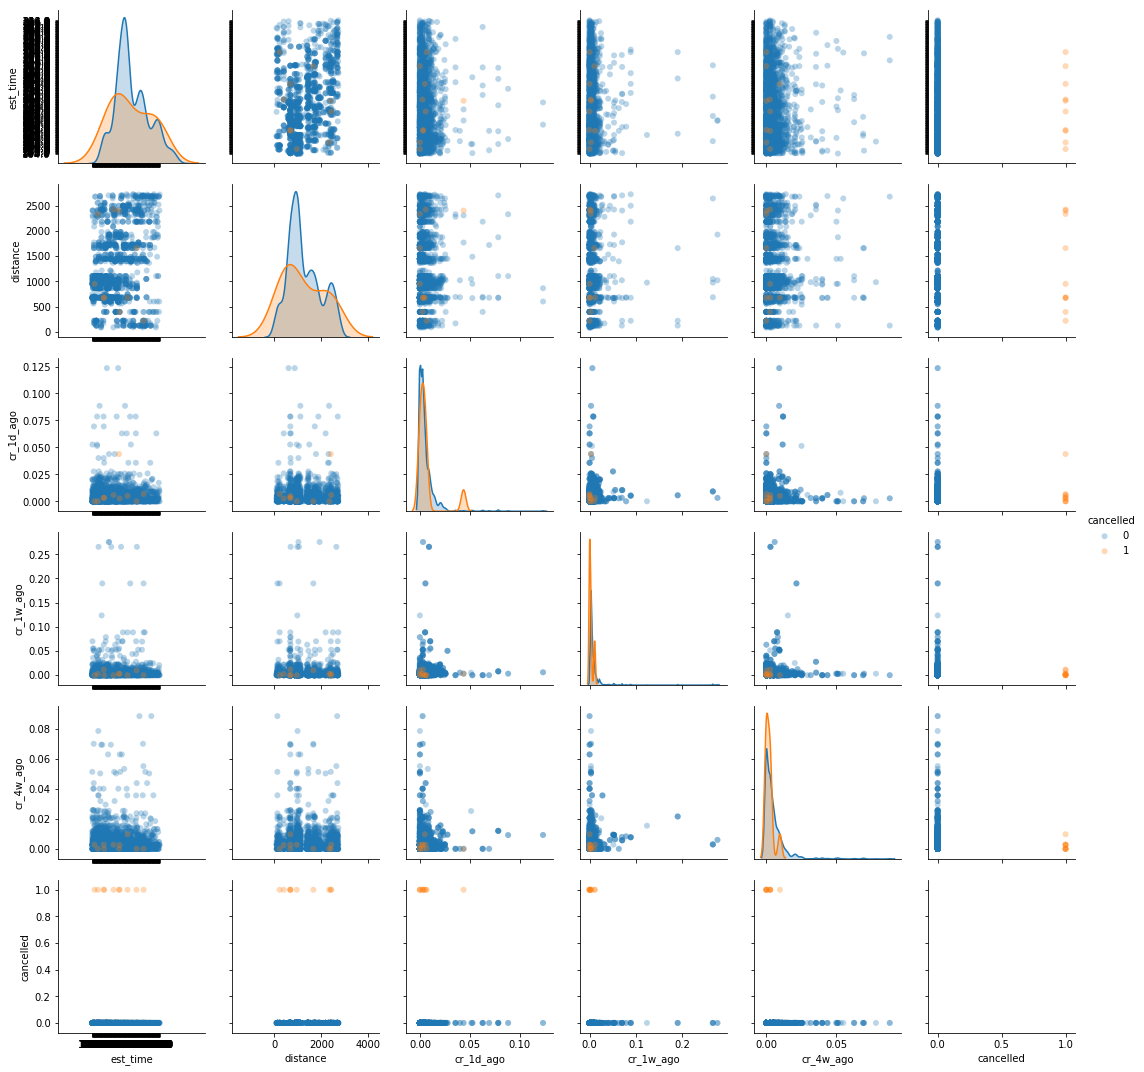

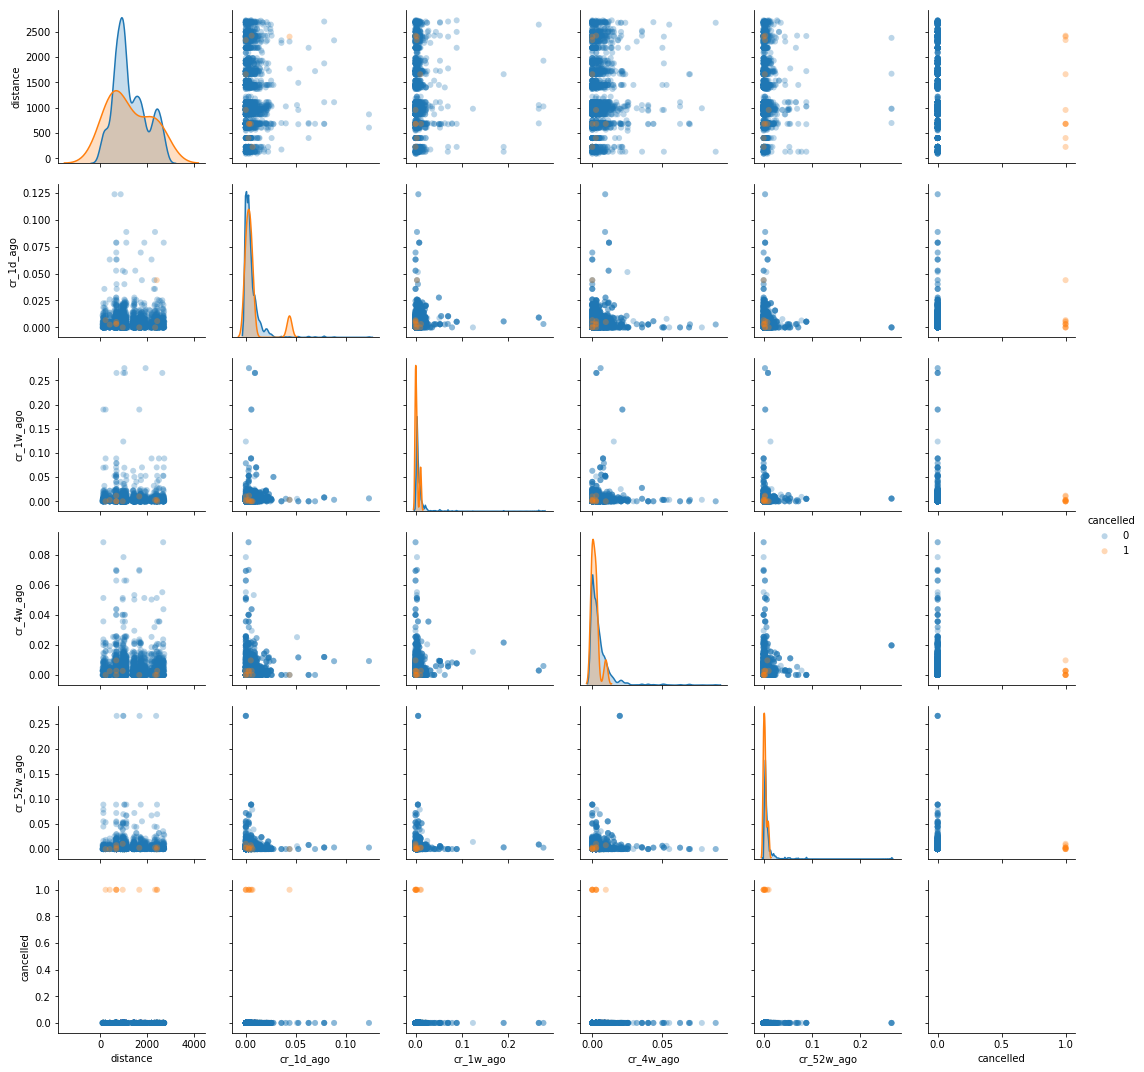

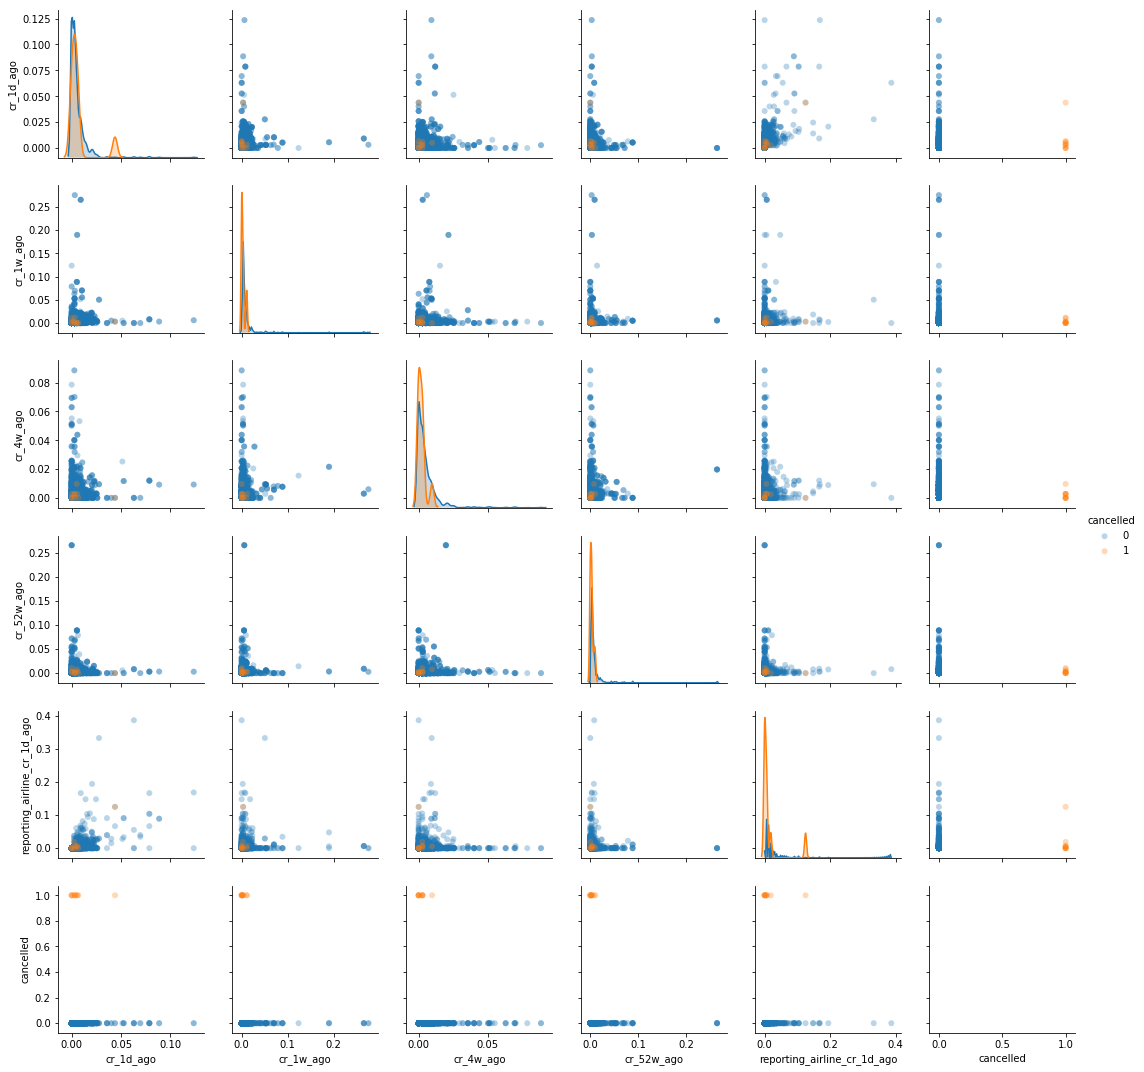

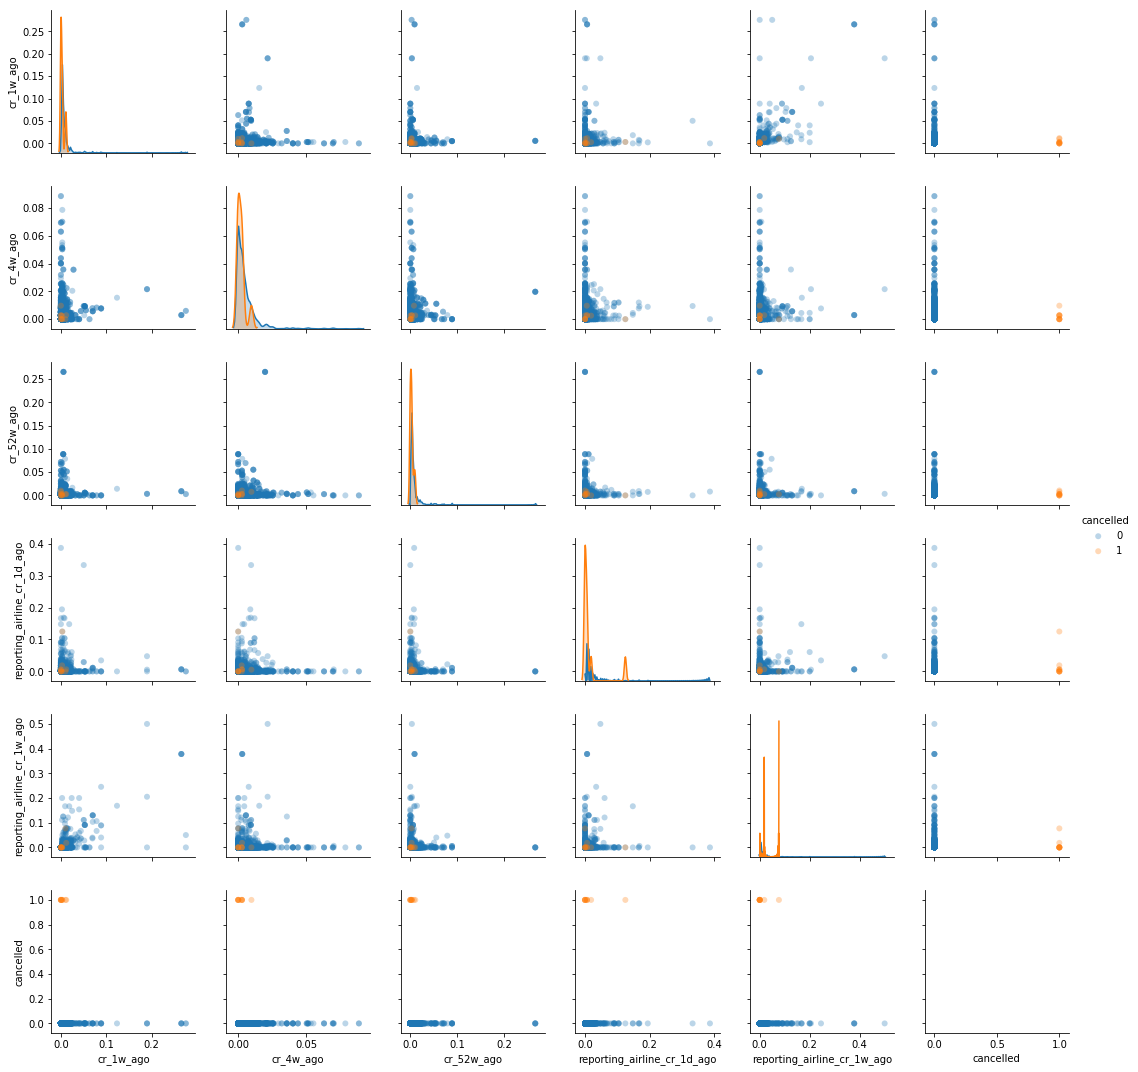

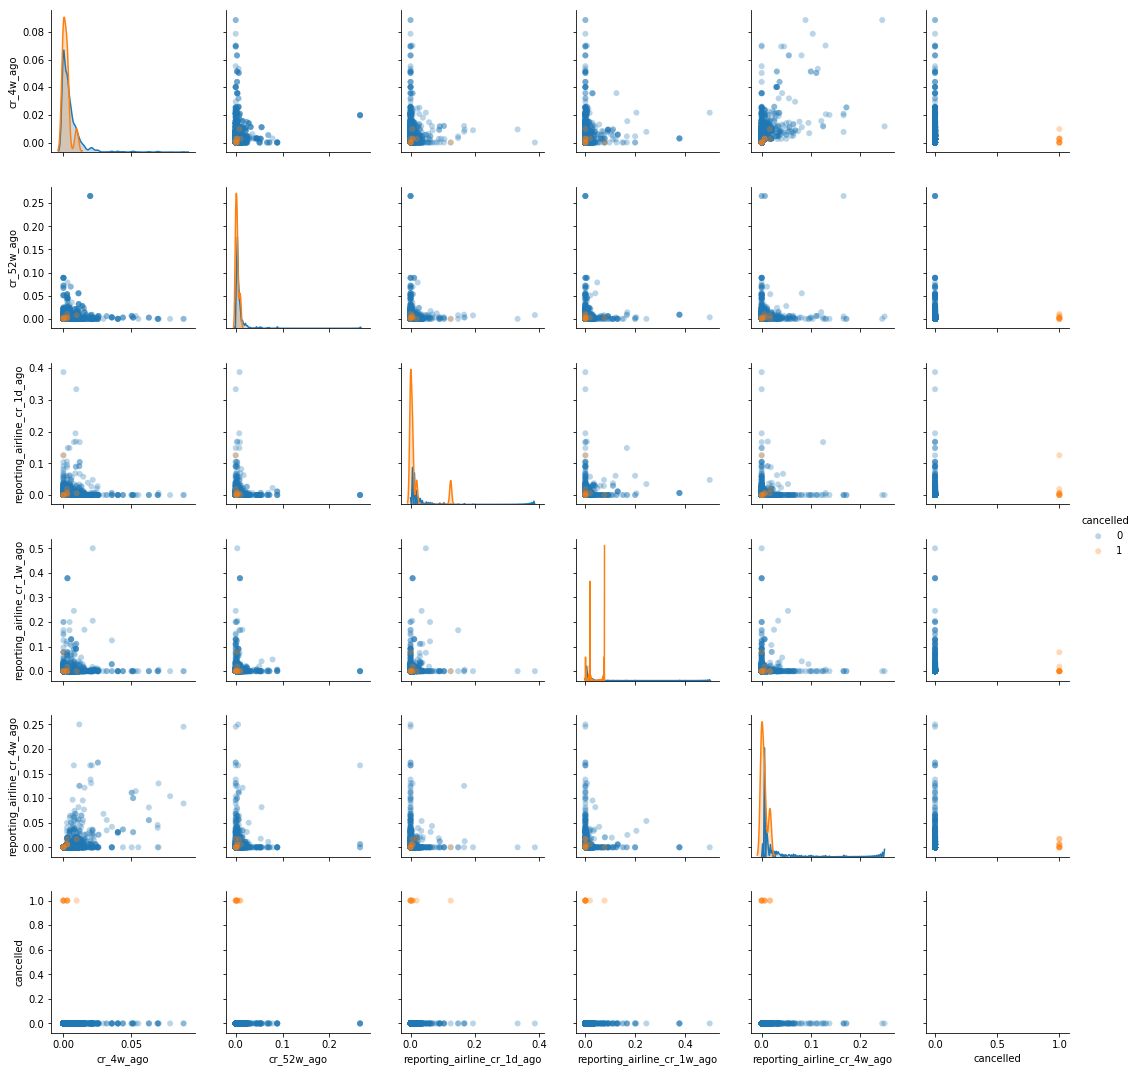

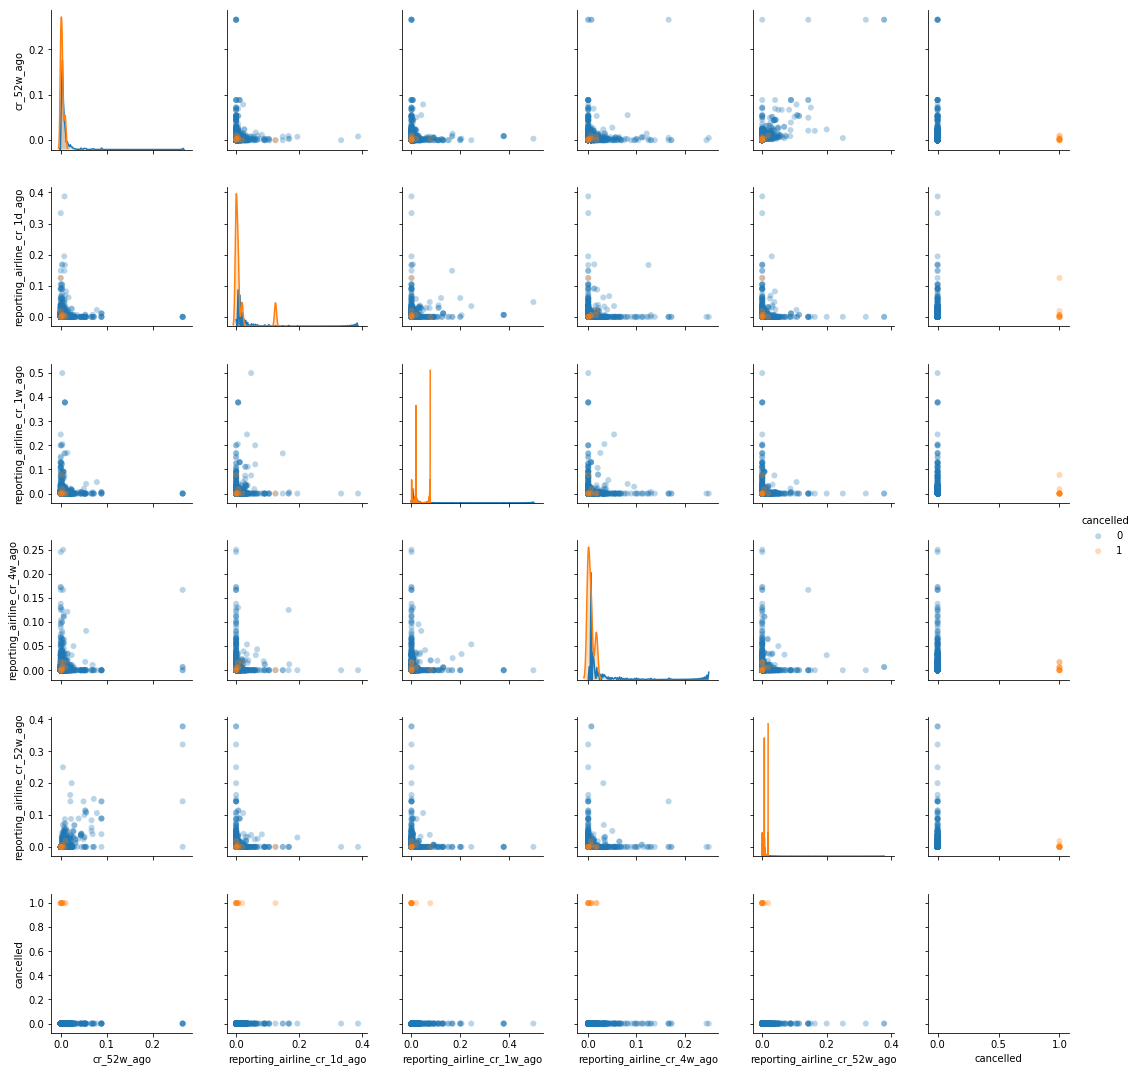

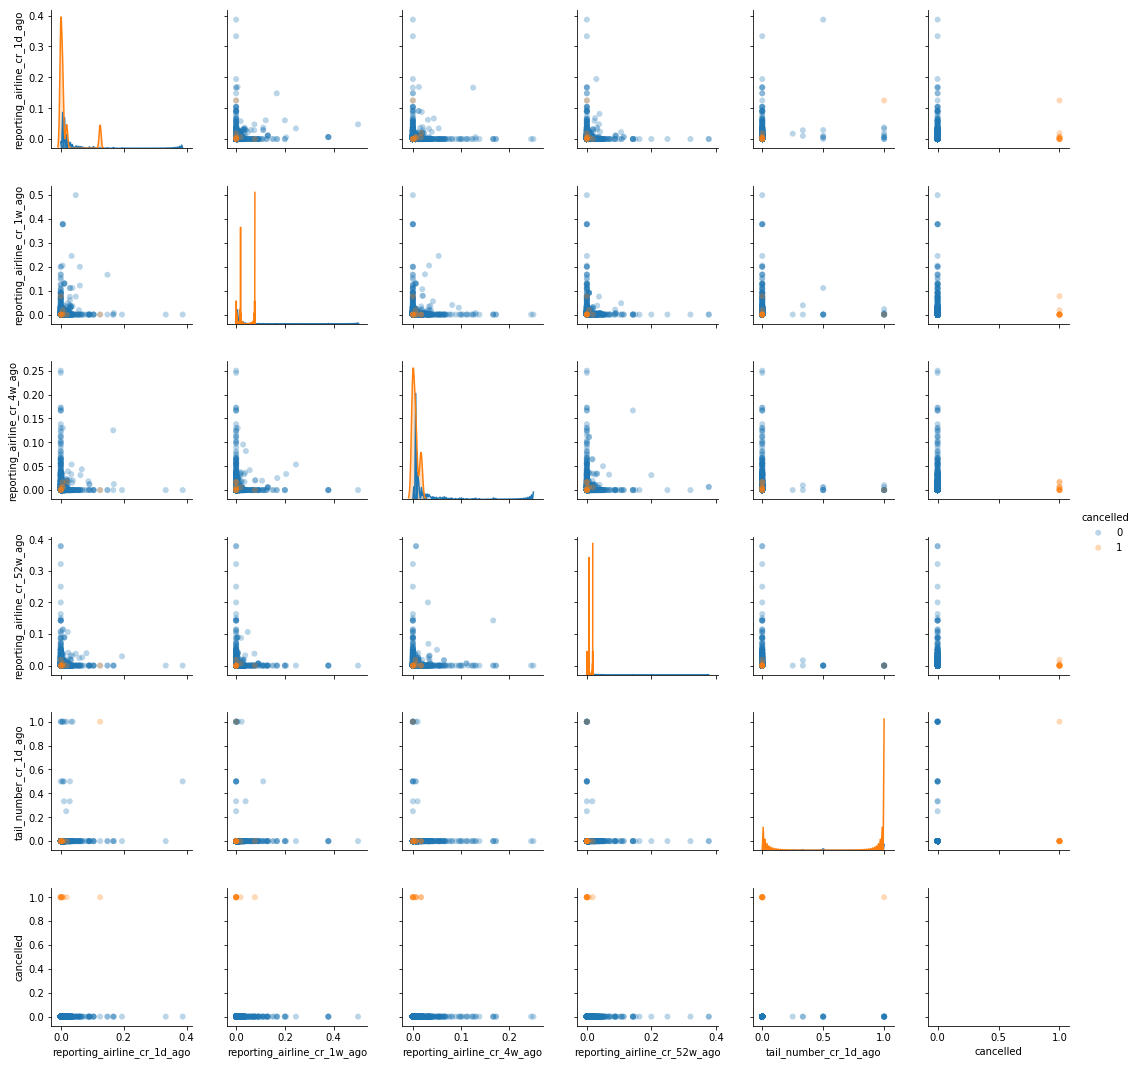

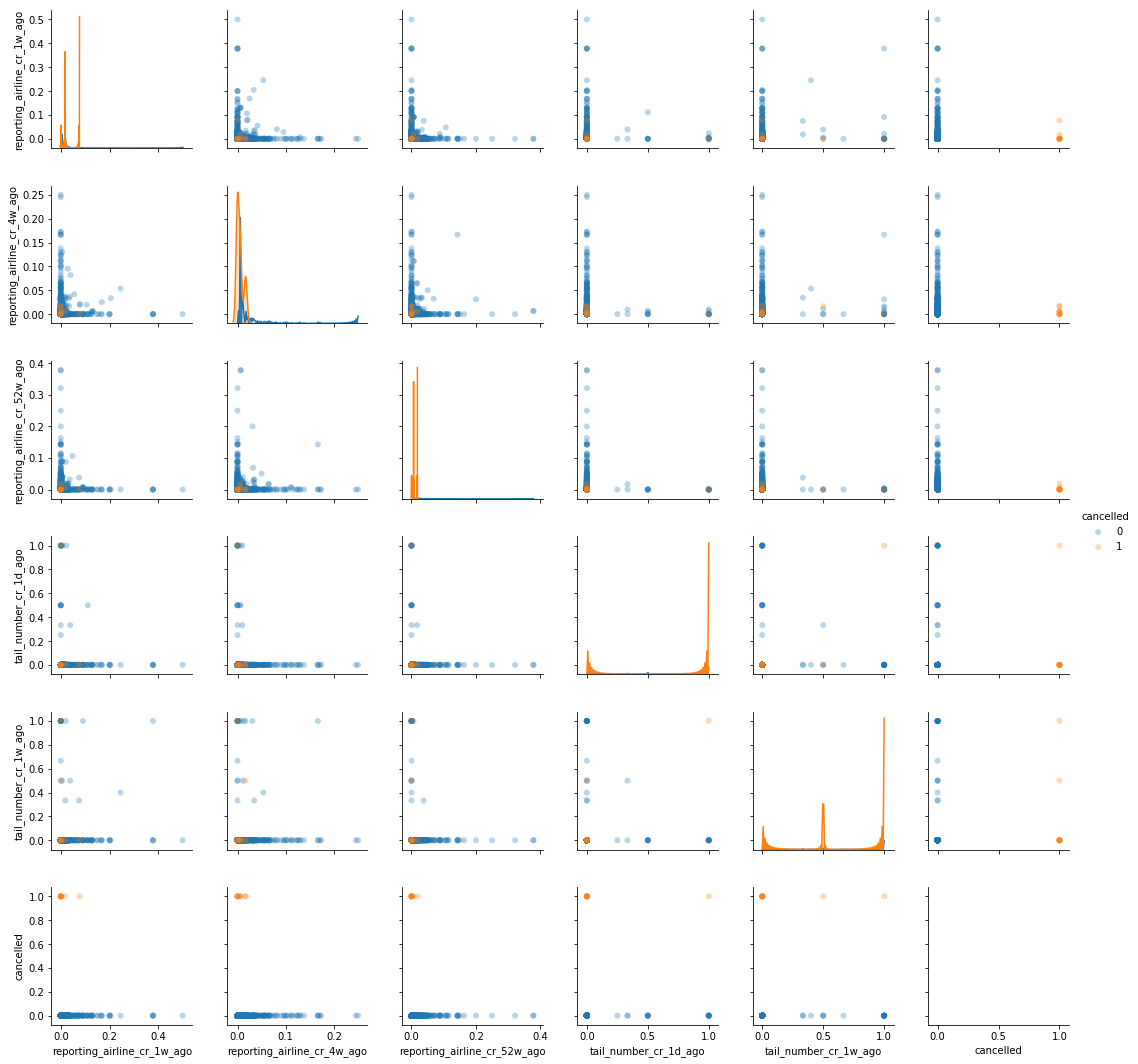

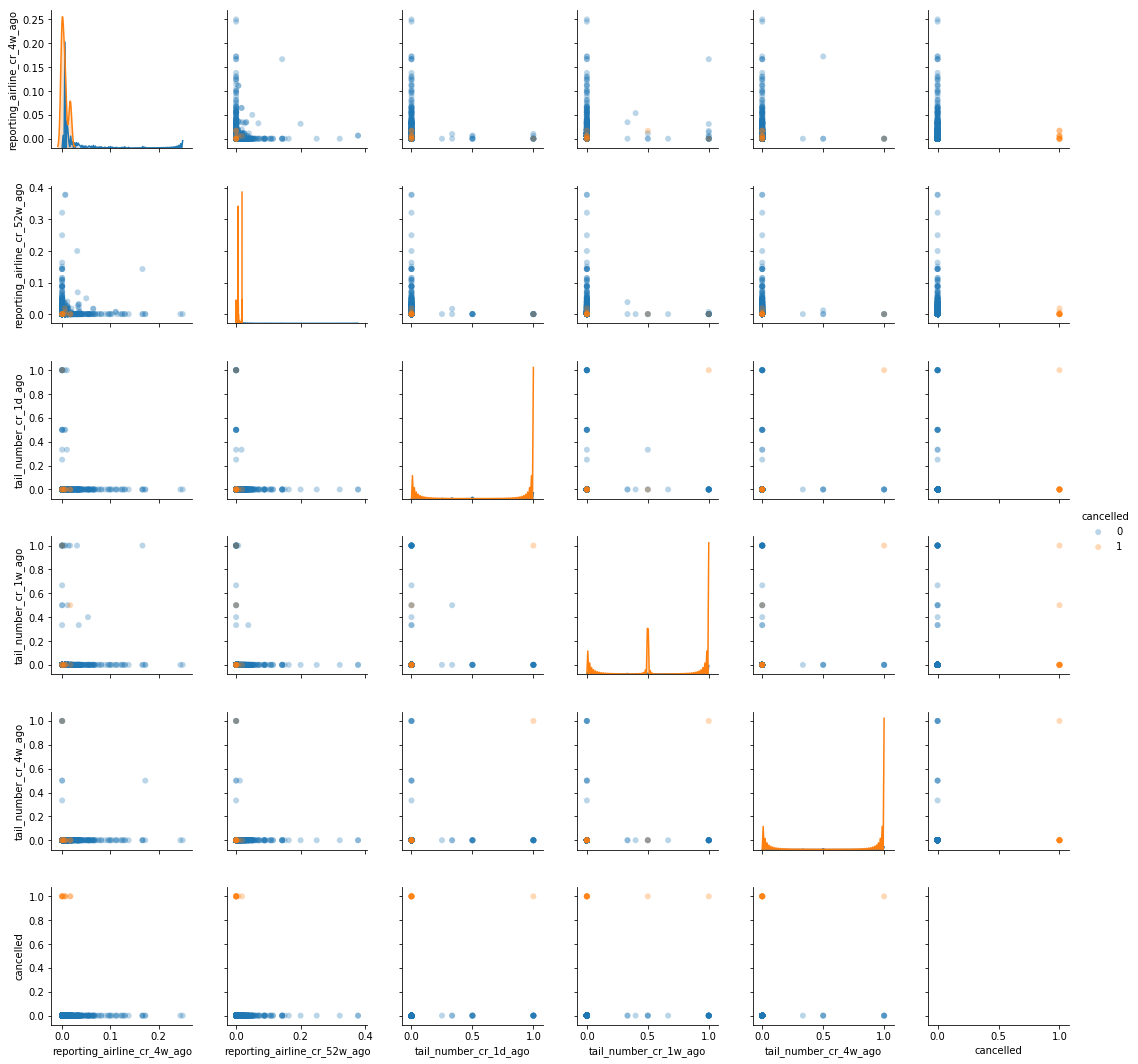

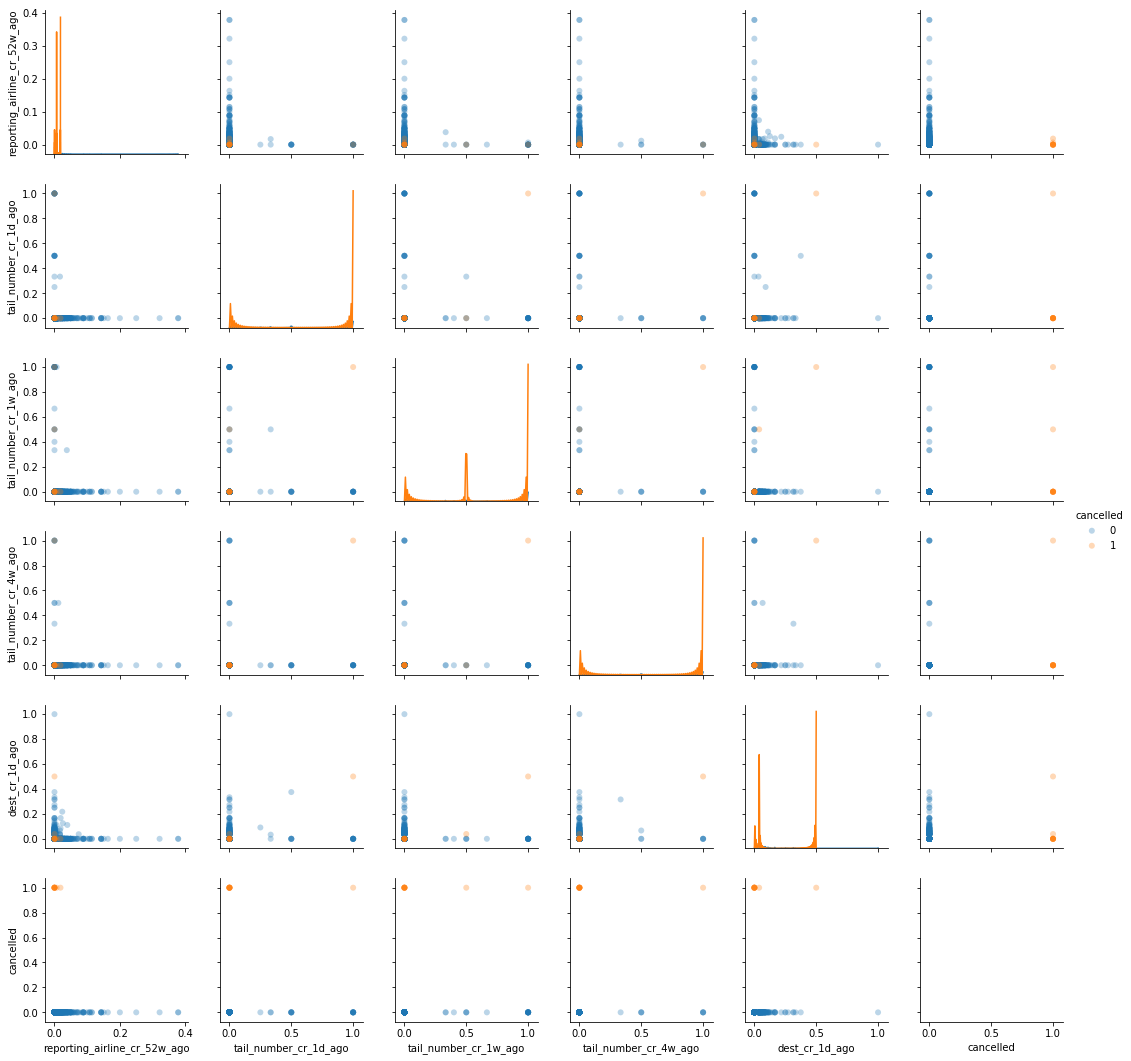

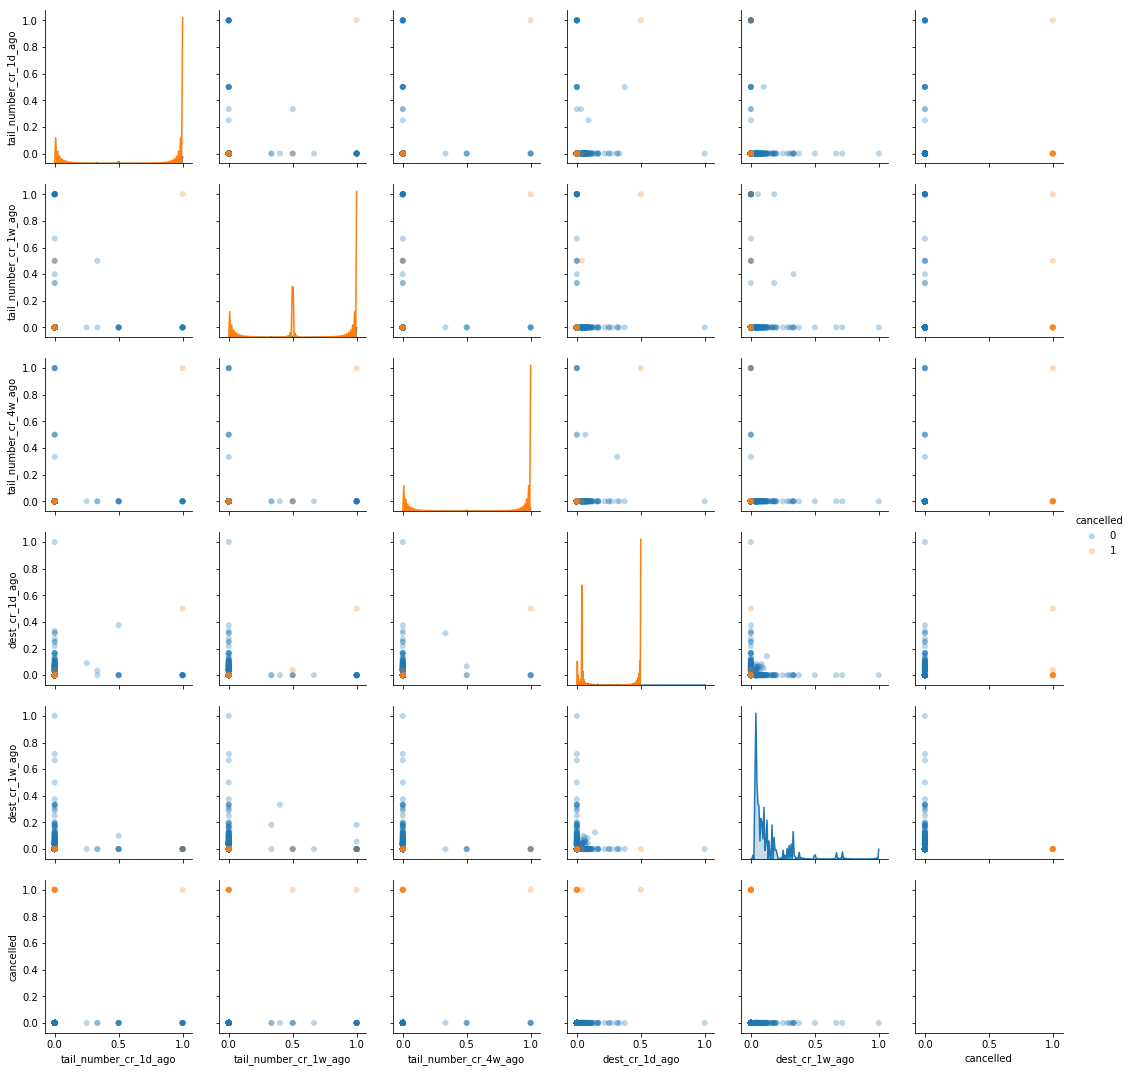

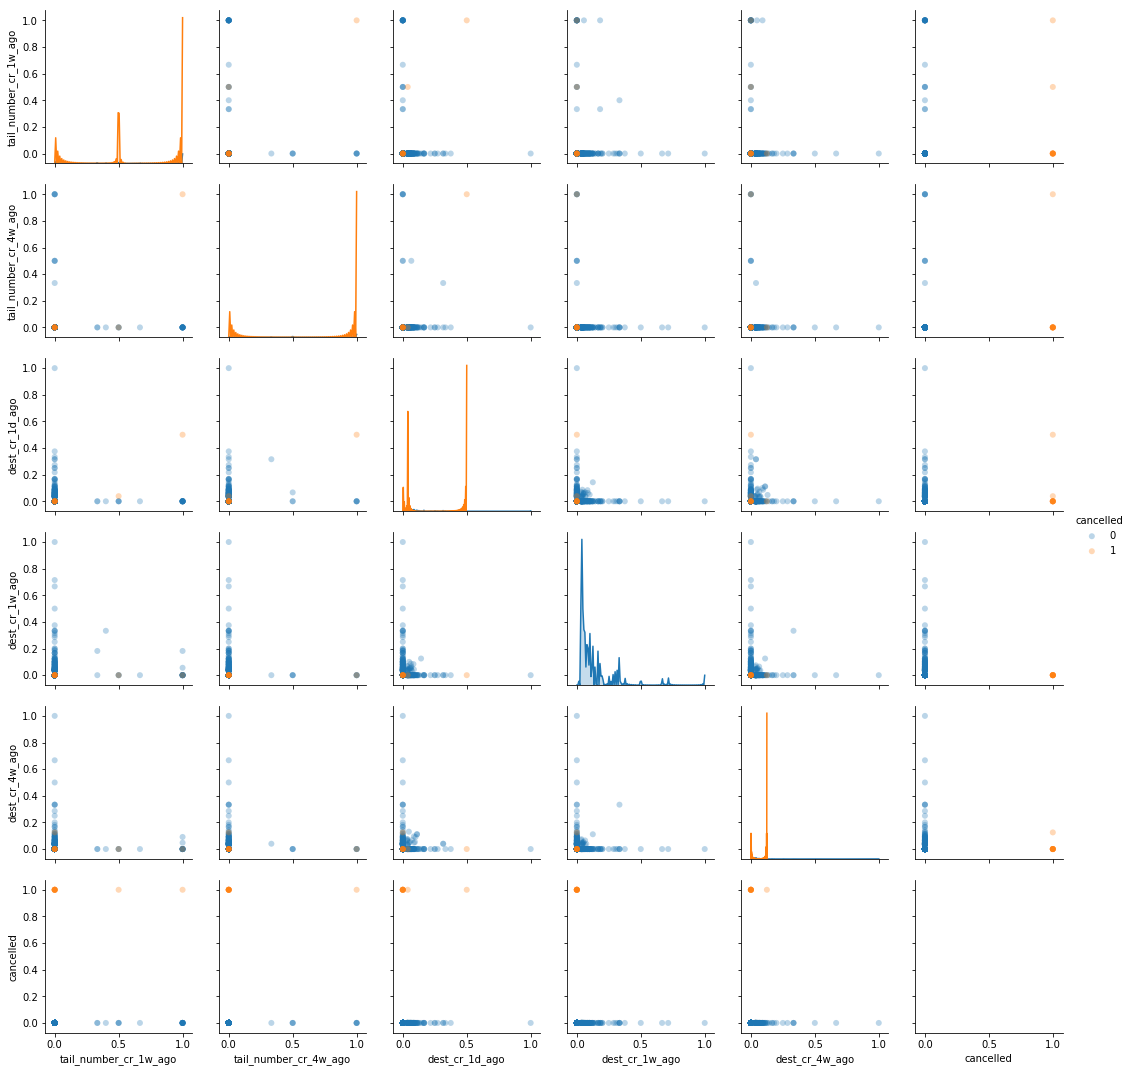

In [265]:
%time data = run()

*What did you learn? What relationships do you think will be most helpful as you build your model?*

# Model the Data

*Describe the algorithm or algorithms that you plan to use to train with your data. How do these algorithms work? Why are they good choices for this data and problem space?*

In [266]:
## %%writefile ../src/models/train_model.py

# Imports
import os
import pickle

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, TimeSeriesSplit, cross_validate
from sklearn import neighbors, neural_network, svm
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier,
    AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')


# Helper functions
def file_exists(path, filename):
    filepath = path + filename
    file_exists = os.path.isfile(filepath)
    return file_exists

def record_results(results):
    """
    Keeps track of model results.
    Input: results (dict), a dictionary of key model attributes
        Results look like:
            results = {
                'Model': 'Logistic Regression', 
                'Notes': 'Classes highly unbalanced; added weather data'
                'Features': 31,
                'Target': 'Cancelled',
                'Train/Test Observations': (320132, 82433),
                'Train Balance': {0: 316931, 1: 3201},
                'Train Score': 0.3, 
                'Test Score': 0.21,
                'Train F1': 0.3,
                'Test F1': 0.2,
                'Hyperparameters': 'solver='lbfgs', 
            }
    Output: record returned as a dataframe and stored as a pickle to persist
    """
    path = '../models/records/'
    filename = 'model_history.pkl'
    filepath = path + filename
    
    if not file_exists(path, filename):
        # If records do not exist yet, create
        columns = list(results.keys())
        record = pd.DataFrame(columns=columns)
    else:
        record = pd.read_pickle(filepath)
        
    record.loc[len(record)] = results
#     display(record.tail(10))
    pd.to_pickle(record, filepath)
    return record


def cost_function(y_actual, y_pred, k=0.1):
    """
    Assigns a score to a set of predictions which represents the proportion of
    available margin that the model captures. A score of 1 indicates perfect
    predictions, capturing all possible savings. A score of zero means that
    following the model results in a wash (i.e. no change in revenue as
    compared to not using the model). A negative score indicates that using the
    model would lose money.
    
    Assigns cost for each prediction according to the following:
        FN: 0
        FP: k - profit / margin
        TN: 0
        TP: k
        
    Values for profit and margin are averages taken from market research, but
    could be improved on if made specific to type of aircraft.
    
    Input: 
        Actual and predicted classification values as lists or listlike objects
        k (default 0.1, i.e. 10%), the proportional improvement an airline can
        make with foreknowledge of a cancellation
    Output:
        A score ranging from {1 - profit/(margin * k), 1}
    """
    profit = 1800
    margin = 2600
    
    # Costs
    d = {
        0: {0: 0,
            1: k - profit / margin},
        1: {0: 0,
            1: k},
    }
    
    classifications = np.stack((y_actual, y_pred)).T
    savings = np.sum([d[a][p] for a, p in classifications])
    score = savings / (np.sum(y_actual) * k)
    return score
    

def save_to(filepath, item):
    """
    Pickles item sand saves it to path
    Input: object to be pickled, string containing directory and filename
    Output: pickled object stored to provided path
    """
    with open(filepath, 'wb') as to_write:
        pickle.dump(item, to_write)
    return


def build_model(method, kwargs={}):
    """
    Instantiates model with given method and hyperparameters
    Input: 
        method (str), name of model to instantiate
            Model options are:
            'KNN',
            'Logistic Regression',
            'Naive Bayes',
            'Linear SVM',
            'Radial SVM',
            'Random Forest',
            'Gradient Boosting',
            'Adaptive Boosting',
            'Linear MLP',
            'Relu MLP'
        kwargs (dict, optional), dictionary of model hyperparameters. If
            omitted, will use defaults.
    Output: instantiated model
    """
    if not kwargs:
        if method == 'Linear MLP':
            kwargs = {'activation': 'identity'}
    
    models = {
        'Logistic Regression': LogisticRegression,
        'KNN': neighbors.KNeighborsClassifier,
        'Naive Bayes': GaussianNB,
        'Linear SVM': svm.LinearSVC,
        'Radial SVM': svm.SVC,
        'Random Forest': RandomForestClassifier,
        'Gradient Boosting': GradientBoostingClassifier,
        'Adaptive Boosting': AdaBoostClassifier,
        'Linear MLP': neural_network.MLPClassifier,
        'Relu MLP': neural_network.MLPClassifier
    }
    model = eval('model(**kwargs)', {'model': models[method], 'kwargs': kwargs})
    
    return model


def save_train_test(cv_train, cv_test, train, test, path):
    """
    Saves train and test data to pickles
    Input: train and test data and path to store pickles in
    Output: pickled files in directory
    """
    save_to(path + 'cv_train.pkl', cv_train)
    save_to(path + 'cv_test.pkl', cv_test)
    save_to(path + 'train.pkl', train)
    save_to(path + 'test.pkl', test)
    pass


def train_test_split(df):
    """
    """
#     tscv = TimeSeriesSplit(n_splits=2)
#     train_index, test_index = tscv.split(df)
    n = df.shape[0]
    cv_train, cv_test = df.iloc[:n//3], df.iloc[n//3 : 2*n//3]
    train, test = df.iloc[:2*n//3], df.iloc[2*n//3:]
    
    return cv_train, cv_test, train, test
    
    
def load_features(filepath):
    """
    Loads data from csv and returns as dataframe
    Input: relative filepath pointing to file
    Output: dataframe containing data from csv
    """
    data = pd.read_pickle(filepath)
    return data


def run(method='Logistic Regression', kwargs={}, desc=''):
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    # Load data
    data = load_features('../data/processed/data.pkl')
    
    # Train-test split
    cv_train, cv_test, train, test = train_test_split(data)
    save_train_test(cv_train, cv_test, train, test, '../data/processed/')
    
    # Train model and predict on cv data
    model = build_model(method, kwargs=kwargs)
    target = 'cancelled'
    X_train, y_train = cv_train.drop(target, axis=1), cv_train[target]
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    train_score = cost_function(y_train, train_pred)
    train_f1 = f1_score(y_train, train_pred)
    train_cm = confusion_matrix(y_train, train_pred)
    save_to('../models/model.pkl', model)
    
    # Prediction time
    X_test, y_test = cv_test.drop(target, axis=1), cv_test[target]
    predictions = model.predict(X_test)
    test_score = cost_function(y_test, predictions)
    test_f1 = f1_score(y_test, predictions)
    test_cm = confusion_matrix(y_test, predictions)

    results = {
        'Model': method, 
        'Desc': desc,
        'Features': X_train.shape[1],
        'Target': target,
        'Train/Test Observations': (X_train.shape[0], X_test.shape[0]),
        'Train Balance': dict(cv_train['cancelled'].value_counts()),
        'Train Score': train_score, 
        'Test Score': test_score,
        'Train F1': train_f1,
        'Test F1': test_f1,
        'Train CM': train_cm,
        'Test CM': test_cm,
        'Hyperparameters': model.get_params(), 
    }
    
    results = record_results(results)
#     metrics = evaluate(cv_test, predictions)
    # save_metrics('reports/')
    return data, model, cv_test, X_test, y_test, predictions, test_score, results

## Run model suite

In [267]:
methods = [
    'Logistic Regression',
    'KNN',
    'Naive Bayes',
    'Linear SVM',
    'Radial SVM',
    'Random Forest',
    'Gradient Boosting',
    'Adaptive Boosting',
    'Linear MLP',
    'Relu MLP']

desc = input('Describe this run: ')

for method in methods:
    print(f'\n{method}')
    %time run(method, desc=desc)
    
record = pd.read_pickle('../models/records/model_history.pkl')
display(record.tail(10))

top_5 = record.sort_values(by='Test Score', ascending=False)
top_5.head()

Describe this run: Added weather data and time blocks

Logistic Regression
CPU times: user 4.75 s, sys: 405 ms, total: 5.15 s
Wall time: 4.13 s

KNN
CPU times: user 21.7 s, sys: 568 ms, total: 22.3 s
Wall time: 21.3 s

Naive Bayes
CPU times: user 3.96 s, sys: 423 ms, total: 4.38 s
Wall time: 2.33 s

Linear SVM
CPU times: user 31.2 s, sys: 426 ms, total: 31.6 s
Wall time: 30.6 s

Radial SVM
CPU times: user 21min 3s, sys: 2.92 s, total: 21min 6s
Wall time: 21min 7s

Random Forest
CPU times: user 3.13 s, sys: 304 ms, total: 3.43 s
Wall time: 3.52 s

Gradient Boosting
CPU times: user 11.3 s, sys: 339 ms, total: 11.6 s
Wall time: 11.7 s

Adaptive Boosting
CPU times: user 21.7 s, sys: 404 ms, total: 22.1 s
Wall time: 6.65 s

Linear MLP
CPU times: user 24.7 s, sys: 605 ms, total: 25.3 s
Wall time: 7.53 s

Relu MLP
CPU times: user 58.8 s, sys: 817 ms, total: 59.6 s
Wall time: 16.2 s


,Model,Desc,Features,Target,Train/Test Observations,Train Balance,Train Score,Test Score,Train F1,Test F1,Train CM,Test CM,Hyperparameters
30,Logistic Regression,Added weather data and time blocks,60,cancelled,"(86743, 86744)","{0: 86297, 1: 446}",0.124181,-0.104187,0.317164,0.111628,"[[86292, 5], [361, 85]]","[[86338, 11], [371, 24]]","{'C': 1.0, 'class_weight': None, 'dual': False..."
31,KNN,Added weather data and time blocks,60,cancelled,"(86743, 86744)","{0: 86297, 1: 446}",-0.035012,-0.059981,0.060215,0.000000,"[[86292, 5], [432, 14]]","[[86345, 4], [395, 0]]","{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
32,Naive Bayes,Added weather data and time blocks,60,cancelled,"(86743, 86744)","{0: 86297, 1: 446}",-40.542601,-37.989484,0.090417,0.064410,"[[83216, 3081], [279, 167]]","[[83799, 2550], [297, 98]]","{'priors': None, 'var_smoothing': 1e-09}"
33,Linear SVM,Added weather data and time blocks,60,cancelled,"(86743, 86744)","{0: 86297, 1: 446}",0.000000,0.000000,0.000000,0.000000,"[[86297, 0], [446, 0]]","[[86349, 0], [395, 0]]","{'C': 1.0, 'class_weight': None, 'dual': True,..."
34,Radial SVM,Added weather data and time blocks,60,cancelled,"(86743, 86744)","{0: 86297, 1: 446}",0.107623,0.000000,0.194332,0.000000,"[[86297, 0], [398, 48]]","[[86349, 0], [395, 0]]","{'C': 1.0, 'cache_size': 200, 'class_weight': ..."
35,Random Forest,Added weather data and time blocks,60,cancelled,"(86743, 86744)","{0: 86297, 1: 446}",0.796309,-0.011685,0.900613,0.117647,"[[86295, 2], [79, 367]]","[[86344, 5], [370, 25]]","{'bootstrap': True, 'class_weight': None, 'cri..."
36,Gradient Boosting,Added weather data and time blocks,60,cancelled,"(86743, 86744)","{0: 86297, 1: 446}",0.181442,-3.367868,0.498361,0.097412,"[[86285, 12], [294, 152]]","[[86119, 230], [363, 32]]","{'criterion': 'friedman_mse', 'init': None, 'l..."
37,Adaptive Boosting,Added weather data and time blocks,60,cancelled,"(86743, 86744)","{0: 86297, 1: 446}",-0.161435,-0.549367,0.296029,0.062500,"[[86271, 26], [364, 82]]","[[86310, 39], [381, 14]]","{'algorithm': 'SAMME.R', 'base_estimator': Non..."
38,Linear MLP,Added weather data and time blocks,60,cancelled,"(86743, 86744)","{0: 86297, 1: 446}",0.090893,-0.336514,0.306542,0.120267,"[[86290, 7], [364, 82]]","[[86322, 27], [368, 27]]","{'activation': 'identity', 'alpha': 0.0001, 'b..."
39,Relu MLP,Added weather data and time blocks,60,cancelled,"(86743, 86744)","{0: 86297, 1: 446}",-0.039324,-0.459202,0.339286,0.089087,"[[86278, 19], [351, 95]]","[[86315, 34], [375, 20]]","{'activation': 'relu', 'alpha': 0.0001, 'batch..."


,Model,Desc,Features,Target,Train/Test Observations,Train Balance,Train Score,Test Score,Train F1,Test F1,Train CM,Test CM,Hyperparameters
24,Radial SVM,Added specific lag cancellations,29,cancelled,"(89862, 89863)","{0: 89334, 1: 528}",0.104167,0.012469,0.188679,0.024631,"[[89334, 0], [473, 55]]","[[89462, 0], [396, 5]]","{'C': 1.0, 'cache_size': 200, 'class_weight': ..."
21,KNN,Added specific lag cancellations,29,cancelled,"(89862, 89863)","{0: 89334, 1: 528}",0.069202,0.004988,0.254486,0.009926,"[[89327, 7], [450, 78]]","[[89462, 0], [399, 2]]","{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
0,Logistic Regression,MVP suite,2,cancelled,"(98828, 98828)","{0: 98213, 1: 615}",0.000000,0.000000,0.000000,0.000000,"[[98213, 0], [615, 0]]","[[98375, 0], [453, 0]]","{'C': 1.0, 'class_weight': None, 'dual': False..."
34,Radial SVM,Added weather data and time blocks,60,cancelled,"(86743, 86744)","{0: 86297, 1: 446}",0.107623,0.000000,0.194332,0.000000,"[[86297, 0], [398, 48]]","[[86349, 0], [395, 0]]","{'C': 1.0, 'cache_size': 200, 'class_weight': ..."
19,Relu MLP,Added lag cancellation data,6,cancelled,"(98828, 98828)","{0: 98213, 1: 615}",0.000000,0.000000,0.000000,0.000000,"[[98213, 0], [615, 0]]","[[98375, 0], [453, 0]]","{'activation': 'relu', 'alpha': 0.0001, 'batch..."


In [846]:
data, model, cv_test, X_test, y_test, predictions, test_score, results = run(
    'Logistic Regression',
    desc='MVP')

In [440]:
## %%writefile ../src/models/predict_model.py

# imports
# helper functions go here
def load_pickle(filepath):
    """
    Opens pickled object stored at filepath
    Input: string containing directory and filename
    Output: pickled object stored to provided path
    """
    with open(filepath, 'rb') as p:
        item = pickle.load(p)
    return item

def load_data(filepath):
    """
    Loads data from csv and returns as dataframe
    Input: relative filepath pointing to file
    Output: dataframe containing data from csv
    """
    data = pd.read_pickle(filepath)
    return data

def load_test_data(path):
    """
    Saves train and test data to pickles
    Input: train and test data and path to store pickles in
    Output: pickled files in directory
    """
    cv_train = load_data(path + 'cv_train.pkl')
    cv_test = load_data(path + 'cv_test.pkl')
    train = load_data(path + 'train.pkl')
    test = load_data(path + 'test.pkl')
    return cv_train, cv_test, train, test


def run():
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    target = 'cancelled'
    cv_train, cv_test, train, test = load_test_data('../data/processed/')
    trained_model = load_pickle('../models/model.pkl')
    X_test, y_test = cv_test.drop(target, axis=1), cv_test[target]
    predictions = trained_model.predict(X_test)
    f1_score = metrics.f1_score(y_test, predictions)
#     metrics = evaluate(cv_test, predictions)
    # save_metrics('reports/')
    return y_test, predictions, f1_score

In [441]:
y_test, predictions, f1_score = run()

/anaconda3/envs/project3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [443]:
y_test.value_counts()

0    196495
1      1157
Name: cancelled, dtype: int64

In [446]:
pd.Series(predictions).value_counts()

0    197652
dtype: int64

In [679]:
args = {'solver': 'liblinear', 'random_state': 42}
l = LogisticRegression(**args)

In [682]:
l.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [683]:
l

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

## Cost function
Based on data from [this site](<https://247wallst.com/services/2014/10/29/the-high-cost-of-cancelled-airline-flights/>):
* On average, a cancellation costs an airline about \$5,770
* That breaks down to about \$3,205 for flights canceled due to an uncontrollable event like weather
* And more like \$9,615 if the cancellation was due to something the airline should have been able to control, such as missing flight crew or maintenance.
* What that means is that about 45% of costs incurred due to cancellations *were avoidable*
* This is extra money goes towards things like inefficient usage of flight and maintenance crews as well as rebooking/reimbursing disgruntled passengers
* This means that on average about $2600 of the money lost due to a cancelled flight is money that the airline didn't have to lose. That's our margin to save from.

This project rests on the assumption that, with sufficient foreknowledge of an impending cancellation, an airline can take early actions in anticipation and cut down on that waste. The scoring function used to validate models is based on this framework, and is parametrically defined in relation to an estimated percentage that an airline can save if they can cancel a flight a day in advance and take cost-saving action then.

From this interpretation, these are my modeled costs of each possible outcome (where *k* is the proportion of the avoidable cost margin that the airline can save with a day's notice, *loss* is that margin (assumed to be \$2,600 on average), and *profit* is the amount of profit the airline would have made if the flight weren't cancelled (assumed to be \$1,800 on average)):

| Result Type    | Interpretation                                            | Savings Proportion        |
| -------------- | --------------------------------------------------------- | ------------------------- |
| True positive  | Correctly predicts that a flight would be cancelled       | $k$                       |
| True negative  | Incorrectly predicts that a flight would not be cancelled | $0$                       |
| False positive | Incorrectly predicts that a flight would be cancelled     | $k-\frac{profit}{margin}$ |
| False negative | Correctly predicts that a flight would not be cancelled   | $0$                       |

The best model is one that maximizes the mean normalized savings across all flights, and the metric indicates that an airline would decrease their losses by $savings * 100 \%$ by following the model's predictions. Put simply, values above 0 are good, 0 means that there'd be no change in revenue from current practices, and values less than 0 would mean that following the model will actually be more expensive for the airline. 

Further interpretation of the costs is as follows: 
* A true positive gets a boost of $k$, as these are the instances where the airline saves money
* Both true and false negatives are treated as nominal results with no penalty, as they would result in no change in current behavior ((naively) assuming airlines aren't already following a prediction model like this). 
* A false positive incurs the same $k$ cost as in a true positive, since the airline would "efficiently" cancel their flight, but is also penalized by a factor of $profit / margin$ to represent the lost profits the airline would have seen had the model not made the incorrect prediction.

_Write down any thoughts you may have about working with these algorithms on this data. What other ideas do you want to try out as you iterate on this pipeline?_

# Interpret the Model

_Write up the things you learned, and how well your model performed. Be sure address the model's strengths and weaknesses. What types of data does it handle well? What types of observations tend to give it a hard time? What future work would you or someone reading this might want to do, building on the lessons learned and tools developed in this project?_